# Exploratory Data Analysis (EDA)

## Why do EDA?

EDA helps uncover statistical properties, temporal patterns, and feature-target relationships that guide model development.  
It ensures we understand the structure and dynamics of the dataset before applying any forecasting models.

---

## EDA Structure

This notebook is organized into the following sections:

1. **Dataset & Feature Summary** – Overview of the data's scope, types, and domains  
2. **Distributional Insights** – Assess distribution shapes, skewness, and transformations  
3. **Time Series Characteristics** – Analyze sampling frequency, time coverage, and seasonality  
4. **Stationarity Analysis** – Evaluate the need for differencing and seasonal modeling  
5. **Autocorrelation Diagnostics** – Explore ACF/PACF patterns and lag dependencies  
6. **Feature Relationships** – Identify correlated predictors via heatmaps and significance testing  
7. **Modeling Strategy** – Summarize EDA-driven insights and justify model selection

## 1. Import Libraries & Load Dataset

We import core libraries and load the raw dataset for downstream analysis.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_parquet('../data/raw/mar_5_may_12.parquet')

df.head()

,timestamp,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,...,mempool_fee_histogram_bin_550_600,mempool_fee_histogram_bin_600_650,mempool_fee_histogram_bin_650_700,mempool_fee_histogram_bin_700_750,mempool_fee_histogram_bin_750_800,mempool_fee_histogram_bin_800_850,mempool_fee_histogram_bin_850_900,mempool_fee_histogram_bin_900_950,mempool_fee_histogram_bin_950_1000,mempool_fee_histogram_bin_1000_plus
0,1741140733,2210077.0,997916.50,556.0,1615739.0,1.300082,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1741140881,2131827.0,997874.25,1030.0,2077770.0,1.300139,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1741141182,1986259.0,997882.00,1915.0,2663152.0,2.000000,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1741141481,1814202.0,997958.25,2710.0,3423846.0,2.413300,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1741141782,1604116.0,997937.50,3256.0,4136741.0,3.008581,4.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.shape

(19799, 83)

## 2. Data Description
The dataset is comprised of Mar. 5 - May. 12, 2025 hourly time series data with 19799 rows × 83 columns (with primarily floating values). The dataset contains the following features:

![](../../img/data_description.png)

## 3. Data Cleaning

To reduce dimensionality and remove irrelevant features, we dropped histogram bin columns whose values were all zero across the dataset. These columns offer no variance or predictive value.

Next, we ensured that the `timestamp` column is properly converted and set as the DataFrame index. This enables correct alignment for downstream time series modeling.

In [5]:
# Filter columns that start with "mempool_fee_histogram_bin_"
hist_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]

# Identify columns where all values are 0.0
zero_hist_cols = [col for col in hist_cols if (df[col] == 0.0).all()]

print("Histogram columns with only 0 float values:")
print(zero_hist_cols)
cols_to_drop = [
    'mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400',
    'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500',
    'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600',
    'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700',
    'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800',
    'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900',
    'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000',
    'mempool_fee_histogram_bin_1000_plus'
]

df.drop(columns=cols_to_drop, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.sort_values('timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)
df.set_index('timestamp', inplace=True)
df = df.iloc[1:]
# df.to_parquet("../data/processed/cleaned.parquet")

Histogram columns with only 0 float values:
['mempool_fee_histogram_bin_300_350', 'mempool_fee_histogram_bin_350_400', 'mempool_fee_histogram_bin_400_450', 'mempool_fee_histogram_bin_450_500', 'mempool_fee_histogram_bin_500_550', 'mempool_fee_histogram_bin_550_600', 'mempool_fee_histogram_bin_600_650', 'mempool_fee_histogram_bin_650_700', 'mempool_fee_histogram_bin_700_750', 'mempool_fee_histogram_bin_750_800', 'mempool_fee_histogram_bin_800_850', 'mempool_fee_histogram_bin_850_900', 'mempool_fee_histogram_bin_900_950', 'mempool_fee_histogram_bin_950_1000', 'mempool_fee_histogram_bin_1000_plus']


In [6]:
df.shape

(19798, 67)

## 4. General Overview

### 4.1 Dataset Summary
Before diving into detailed visualizations, we first examine the dataset structure and basic statistics. This step helps verify the completeness of the data and highlights potential issues that may impact feature distributions or modeling later on.

In [7]:
print(f"Dataset shape: {df.shape}")
df.info()
df.describe(include='all').T

Dataset shape: (19798, 67)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19798 entries, 2025-03-05 02:14:41 to 2025-05-12 19:59:41
Data columns (total 67 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   mempool_blocks_blockSize                  19797 non-null  float64
 1   mempool_blocks_blockVSize                 19797 non-null  float64
 2   mempool_blocks_nTx                        19797 non-null  float64
 3   mempool_blocks_totalFees                  19797 non-null  float64
 4   mempool_blocks_medianFee                  19797 non-null  float64
 5   recommended_fee_fastestFee                19798 non-null  float64
 6   recommended_fee_halfHourFee               19798 non-null  float64
 7   recommended_fee_hourFee                   19798 non-null  float64
 8   recommended_fee_economyFee                19798 non-null  float64
 9   recommended_fee_minimumFee                1

,count,mean,std,min,25%,50%,75%,max
mempool_blocks_blockSize,19797.0,1.607857e+06,3.942101e+05,7501.00,1.515894e+06,1.629756e+06,1.746011e+06,3.914498e+06
mempool_blocks_blockVSize,19797.0,9.509390e+05,1.681826e+05,4367.25,9.979165e+05,9.979565e+05,9.979835e+05,9.979998e+05
mempool_blocks_nTx,19797.0,2.764964e+03,1.177938e+03,15.00,1.905000e+03,2.949000e+03,3.651000e+03,6.408000e+03
mempool_blocks_totalFees,19797.0,4.079149e+06,3.701828e+06,15658.00,2.116165e+06,3.212762e+06,4.890239e+06,8.107809e+07
mempool_blocks_medianFee,19797.0,2.817556e+00,4.733157e+00,0.00,1.288066e+00,2.047615e+00,3.154065e+00,2.731774e+02
...,...,...,...,...,...,...,...,...
mempool_fee_histogram_bin_95_100,19798.0,1.280973e+01,8.060690e+02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,5.217400e+04
mempool_fee_histogram_bin_100_150,19798.0,1.183400e+03,1.225070e+04,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.117370e+05
mempool_fee_histogram_bin_150_200,19798.0,2.226801e+02,3.703575e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,6.893900e+04
mempool_fee_histogram_bin_200_250,19798.0,7.076195e+01,2.137248e+03,0.00,0.000000e+00,0.000000e+00,0.000000e+00,9.550100e+04


#### Key Insights:
- All columns are of type `float64` and contain no missing values.
- Many of the larger fee histogram bins contain a high proportion of zeros.
- We observed anomalies in the `price_USD` feature, where the minimum value is `-1`.
- We further investigate this issue before exploring the distribution of each feature.

### 4.2 Anomaly Check
We inspect the `price_USD` column for potential anomalies before modeling. Anomalies like placeholder values (e.g., `-1`) can bias statistical summaries or models if left untreated.
We focus on `price_USD` because it is the most commonly referenced and stable fiat benchmark for Bitcoin.

In [8]:
anomaly_prices = df[df['price_USD'] == -1]
anomaly_count = anomaly_prices.shape[0]
anomaly_timestamps = anomaly_prices.index 

print(f"Number of -1 values in 'price_USD': {anomaly_count}")
print(f"Timestamps (or indices) with -1 values: {anomaly_timestamps}")

Number of -1 values in 'price_USD': 4
Timestamps (or indices) with -1 values: DatetimeIndex(['2025-04-07 21:29:41', '2025-04-07 21:34:41',
               '2025-04-07 21:39:42', '2025-04-11 16:44:41'],
              dtype='datetime64[ns]', name='timestamp', freq=None)


#### Key Insights:
- Out of 19,798 rows, only 4 entries in the price_USD column have a value of -1.
- This likely indicates missing price data during those hours.
- Given the minimal impact, these rows can either be dropped or handled using simple imputation.

### 4.3 FastestFee Time Series with Mean, Median, and 99th Percentile
We analyze the time series of `fastestFee` to understand its overall range and identify any extreme spikes. Plotting summary statistics (mean, median, and 99th percentile) helps contextualize the fee environment and highlights abnormal behaviors that may influence modeling decisions.

![FastestFee](../results/plots/fee_peaks_summary.png)

In [10]:
print(top2)

timestamp
2025-05-12 14:59:41    52.0
2025-05-12 15:29:42    52.0
Name: recommended_fee_fastestFee, dtype: float64


#### Key Insights:

- The `fastestFee` series exhibits occasional extreme spikes.
- The mean and 99th percentile lines help contextualize these spikes relative to the baseline fee levels.
- Most values cluster around the median (≈3 sats/vByte), with a few significant outliers exceeding 40 sats/vByte.
- These outliers suggest sudden demand surges likely caused by short-term network congestion or user behavior spikes.

## 5. Feature Description Distribution
To build accurate forecasting models, it's essential to understand the key features involved — what they represent, how they're measured, and how they're distributed. This section summarizes the core variables in the dataset and prepares for deeper distributional analysis.

### 5.1 Summary Table of Key Features
This section provides a summary of key features in the dataset, categorized by purpose. Each feature is briefly described to support interpretability and guide downstream analysis.

We focus on variables related to mempool activity, projected block structure, fee rates, difficulty adjustment, and Bitcoin market conditions. Histogram bin variables (e.g., `mempool_fee_histogram_bin_1_2`) are grouped and interpreted based on fee range density.

| Feature                                  | Description                                            |
|:-----------------------------------------|:-------------------------------------------------------|
| mempool_blocks_blockSize                 | Total raw block size of pending transactions (bytes)   |
| mempool_blocks_blockVSize                | Virtual size of pending block (vBytes)                 |
| mempool_blocks_nTx                       | Number of transactions in the estimated next block     |
| mempool_blocks_totalFees                 | Total fees expected in next block (satoshis)           |
| mempool_blocks_medianFee                 | Median fee rate in the next block (sats/vB)            |
| recommended_fee_fastestFee               | Recommended fee for fastest confirmation (sats/vB)     |
| recommended_fee_halfHourFee              | Recommended fee for confirmation within 30 mins        |
| recommended_fee_hourFee                  | Recommended fee for confirmation within 1 hour         |
| recommended_fee_economyFee               | Recommended low-priority fee (slower confirmation)     |
| recommended_fee_minimumFee               | Minimum fee needed to enter the mempool                |
| mempool_count                            | Number of unconfirmed transactions in the mempool      |
| mempool_vsize                            | Total virtual size of mempool (vBytes)                 |
| mempool_total_fee                        | Total fee volume of mempool (sats)                     |
| difficulty_adjustment_progressPercent    | Progress toward next difficulty adjustment (%)         |
| difficulty_adjustment_difficultyChange   | Expected difficulty change (%)                         |
| difficulty_adjustment_remainingBlocks    | Blocks left until next difficulty adjustment           |
| difficulty_adjustment_remainingTime      | Estimated time until difficulty adjustment (sec)       |
| difficulty_adjustment_previousTime       | Time taken for the previous difficulty epoch (sec)     |
| difficulty_adjustment_nextRetargetHeight | Height at which next difficulty retarget occurs        |
| difficulty_adjustment_timeAvg            | Average time between blocks in the current epoch (sec) |
| difficulty_adjustment_adjustedTimeAvg    | Adjusted average block time considering skew           |
| difficulty_adjustment_timeOffset         | Time offset vs. expected block production              |
| difficulty_adjustment_expectedBlocks     | Expected blocks per difficulty period                  |
| price_USD                                | Bitcoin market price in USD                            |
| price_EUR                                | Bitcoin market price in EUR                            |
| price_GBP                                | Bitcoin market price in GBP                            |
| price_CAD                                | Bitcoin market price in CAD                            |
| price_CHF                                | Bitcoin market price in CHF                            |
| price_AUD                                | Bitcoin market price in AUD                            |
| price_JPY                                | Bitcoin market price in JPY                            |
| mempool_fee_histogram_bin_               | Each mempool_fee_histogram_bin_* feature represents the number of transactions in the mempool whose fee rate falls within a specific sats/vB range (e.g., bin_1_2 means 1–2 sats/vB).|

### 5.2 Mempool Block Features

This section examines the distribution of mempool block features, such as transaction count, block size, and expected fees. These variables help characterize network demand and congestion levels.

Each histogram below shows the distribution of a `mempool_blocks_` feature. The goal is to understand variability, detect skewness, and assess whether transformation may be beneficial.


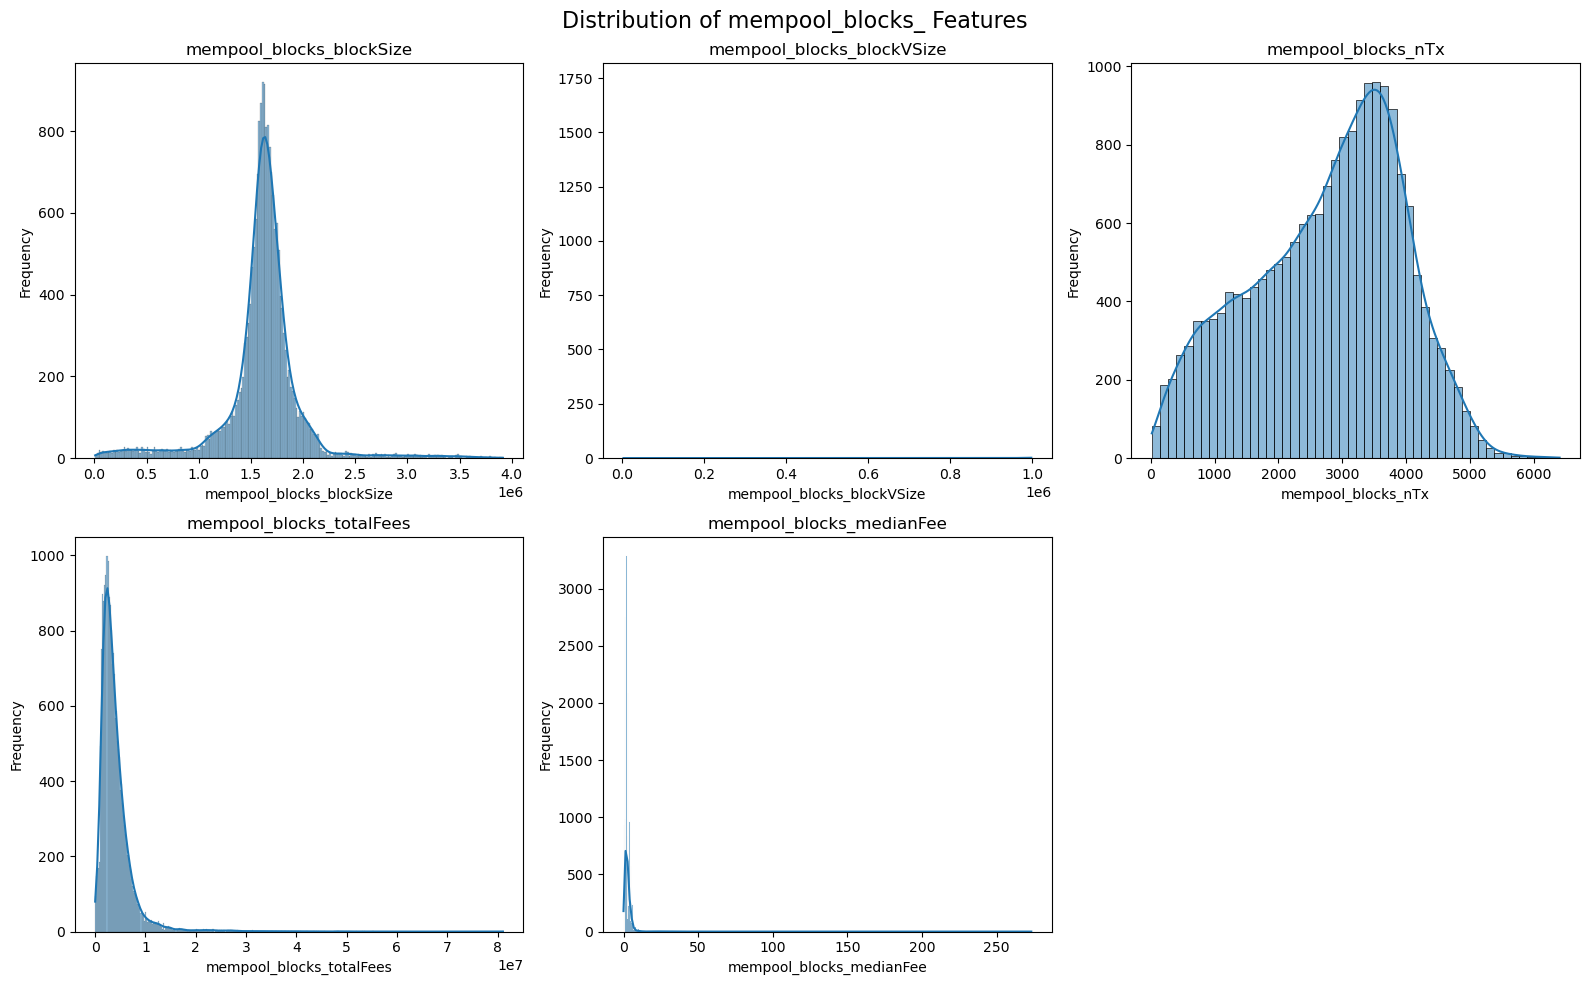

In [11]:
def plot_feature_group(df, prefix, max_cols=3, figsize=(16, 10)):
    """
    Plots the distribution (histogram with KDE) of all features in the DataFrame that start with a given prefix.

    Parameters:
    ----------
    df : pd.DataFrame
        The DataFrame containing the feature columns to be plotted.
    prefix : str
        The prefix string used to filter column names.
    max_cols : int, optional (default=3)
        Maximum number of plots per row.
    figsize : tuple, optional (default=(16, 10))
        Size of the entire figure.

    Returns:
    -------
    None
        Displays the matplotlib figure inline.
    """
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    n = len(group_cols)
    rows = (n + max_cols - 1) // max_cols
    fig, axes = plt.subplots(rows, max_cols, figsize=figsize, squeeze=False)
    
    for i, col in enumerate(group_cols):
        ax = axes[i // max_cols][i % max_cols]
        sns.histplot(df[col].dropna(), kde=True, ax=ax)
        ax.set_title(col)
        ax.set_ylabel("Frequency")
    for j in range(i+1, rows * max_cols):
        fig.delaxes(axes[j // max_cols][j % max_cols])

    fig.suptitle(f"Distribution of {prefix} Features", fontsize=16)
    fig.tight_layout()
    plt.show()

plot_feature_group(df, "mempool_blocks_")


#### Key Insights:
- Most `mempool_blocks_` features are continuous and non-negative.  
- Some variables (e.g., `mempool_blocks_totalFees`, `mempool_blocks_medianFee`) exhibit heavy right skew due to occasional fee spikes.  
- These patterns reflect the bursty nature of blockchain activity and may motivate log transformation for variance stabilization in modeling.

### 5.3 Mempool State Features
The mempool state features describe the overall size and volume of pending transactions in the Bitcoin network.

These variables are important indicators of network congestion and transaction pressure. Their distributional characteristics may influence model selection or transformations.


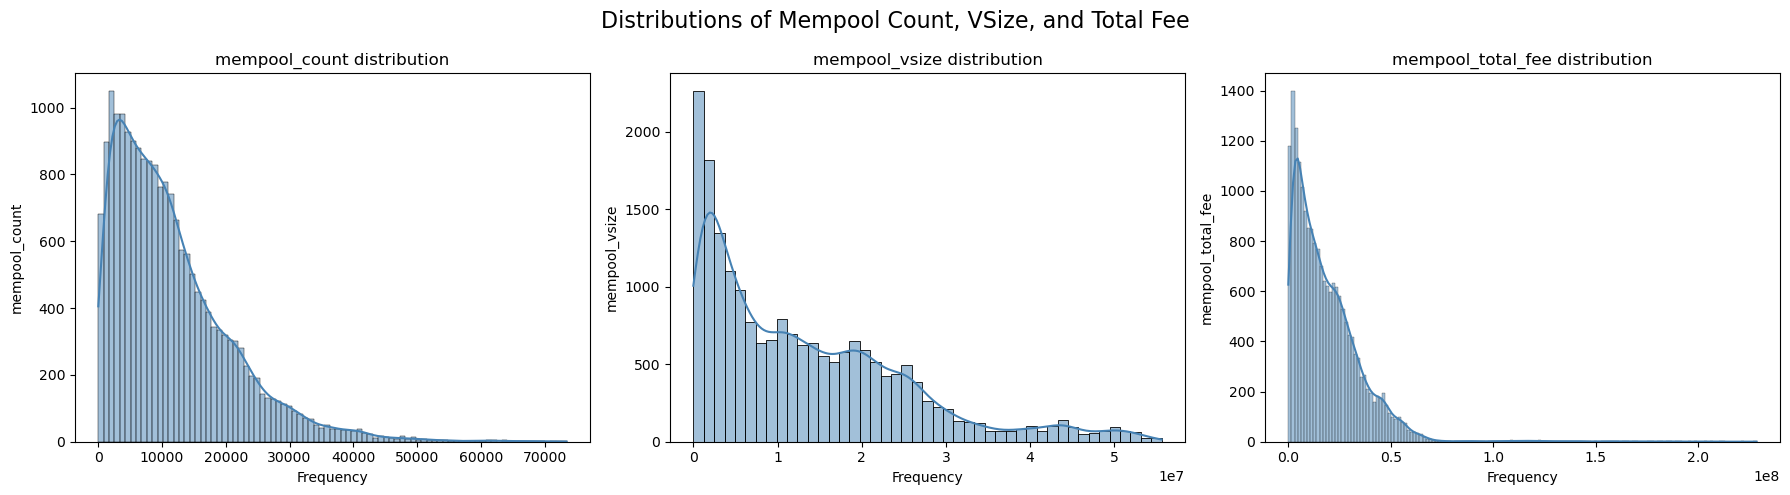

In [12]:
features = ["mempool_count", "mempool_vsize", "mempool_total_fee"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i], color="steelblue")
    axes[i].set_title(f"{feature} distribution")
    axes[i].set_ylabel(feature)
    axes[i].set_xlabel("Frequency")

fig.suptitle("Distributions of Mempool Count, VSize, and Total Fee", fontsize=16)
plt.tight_layout()
plt.show()

#### Key Insights:
- `mempool_count`, `mempool_vsize`, and `mempool_total_fee` all exhibit strong right-skewness with long tails.
- A log transformation or outlier trimming may help stabilize variance and improve model fit.


### 5.4 Difficulty Adjustment Features
This section explores features related to Bitcoin's mining difficulty adjustment process. These variables help track progress, timing, and expected block targets across difficulty epochs. Understanding their distributions can inform how temporal or periodic structures might influence modeling.

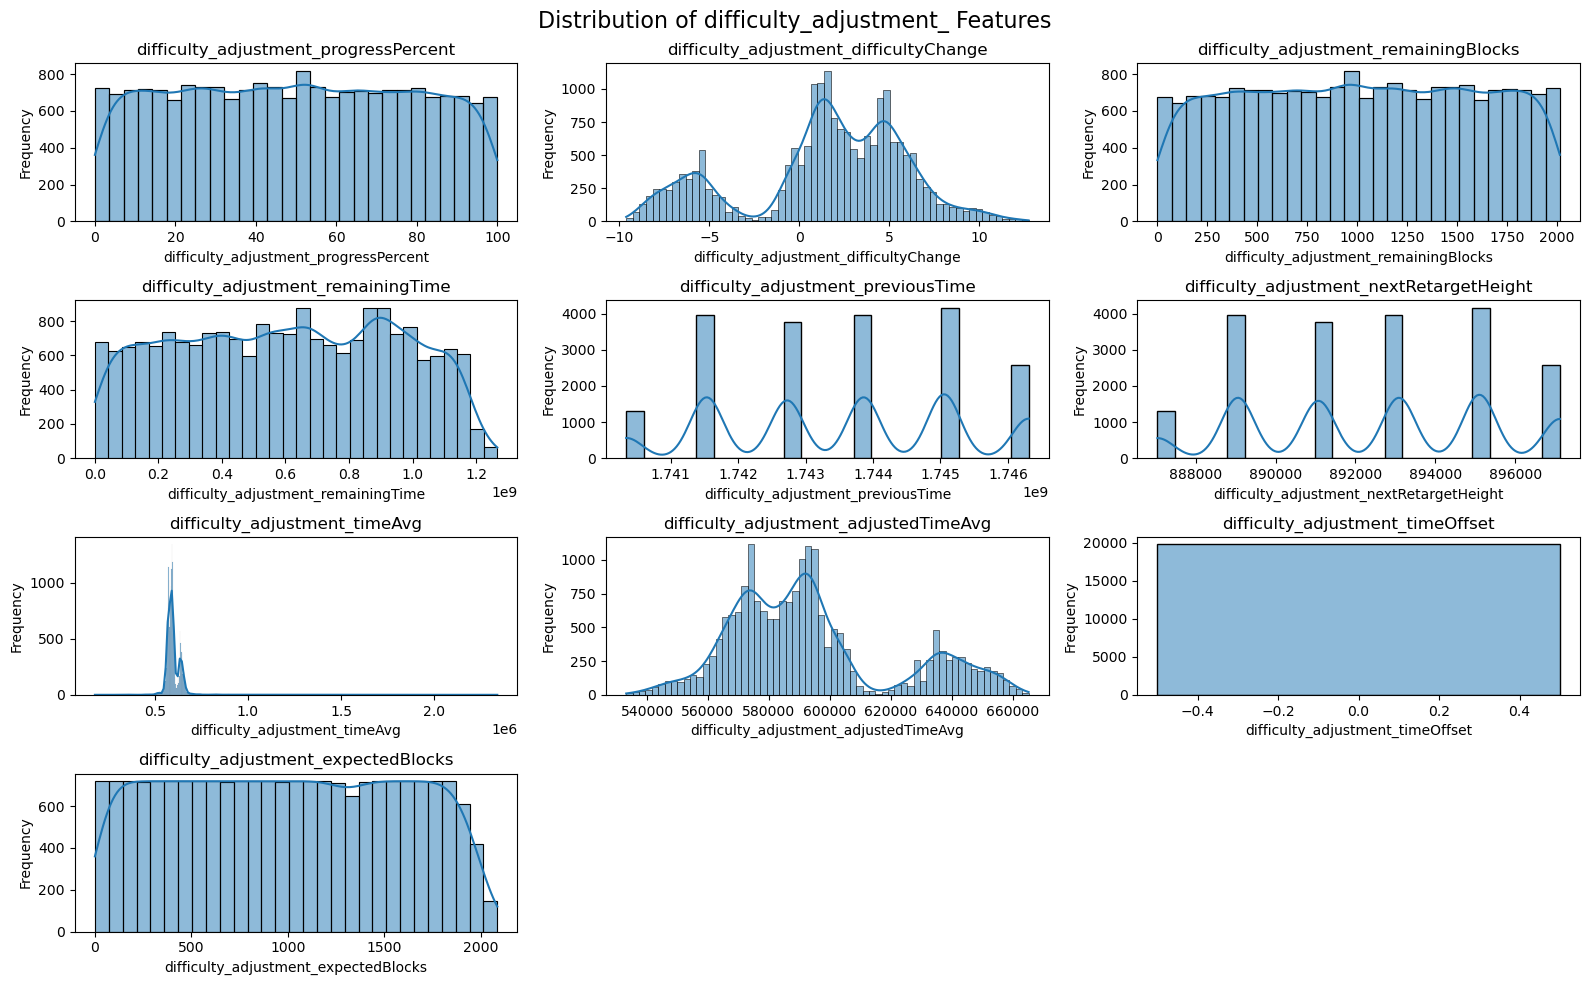

In [13]:
plot_feature_group(df, "difficulty_adjustment_")


#### Key Insights:

- Features like `difficulty_adjustment_progressPercent` and `difficulty_adjustment_expectedBlocks` appear roughly uniform or multi-modal, reflecting variability across epochs.
- Discrete spikes in `previousTime` and `nextRetargetHeight` correspond to deterministic retarget boundaries—these may serve as useful epoch markers.

### 5.5 Price Features
We analyze the distribution of Bitcoin prices in multiple currencies to evaluate their variability and potential need for transformation. These features serve as external market indicators and may contribute to modeling performance if aligned with fee dynamics.

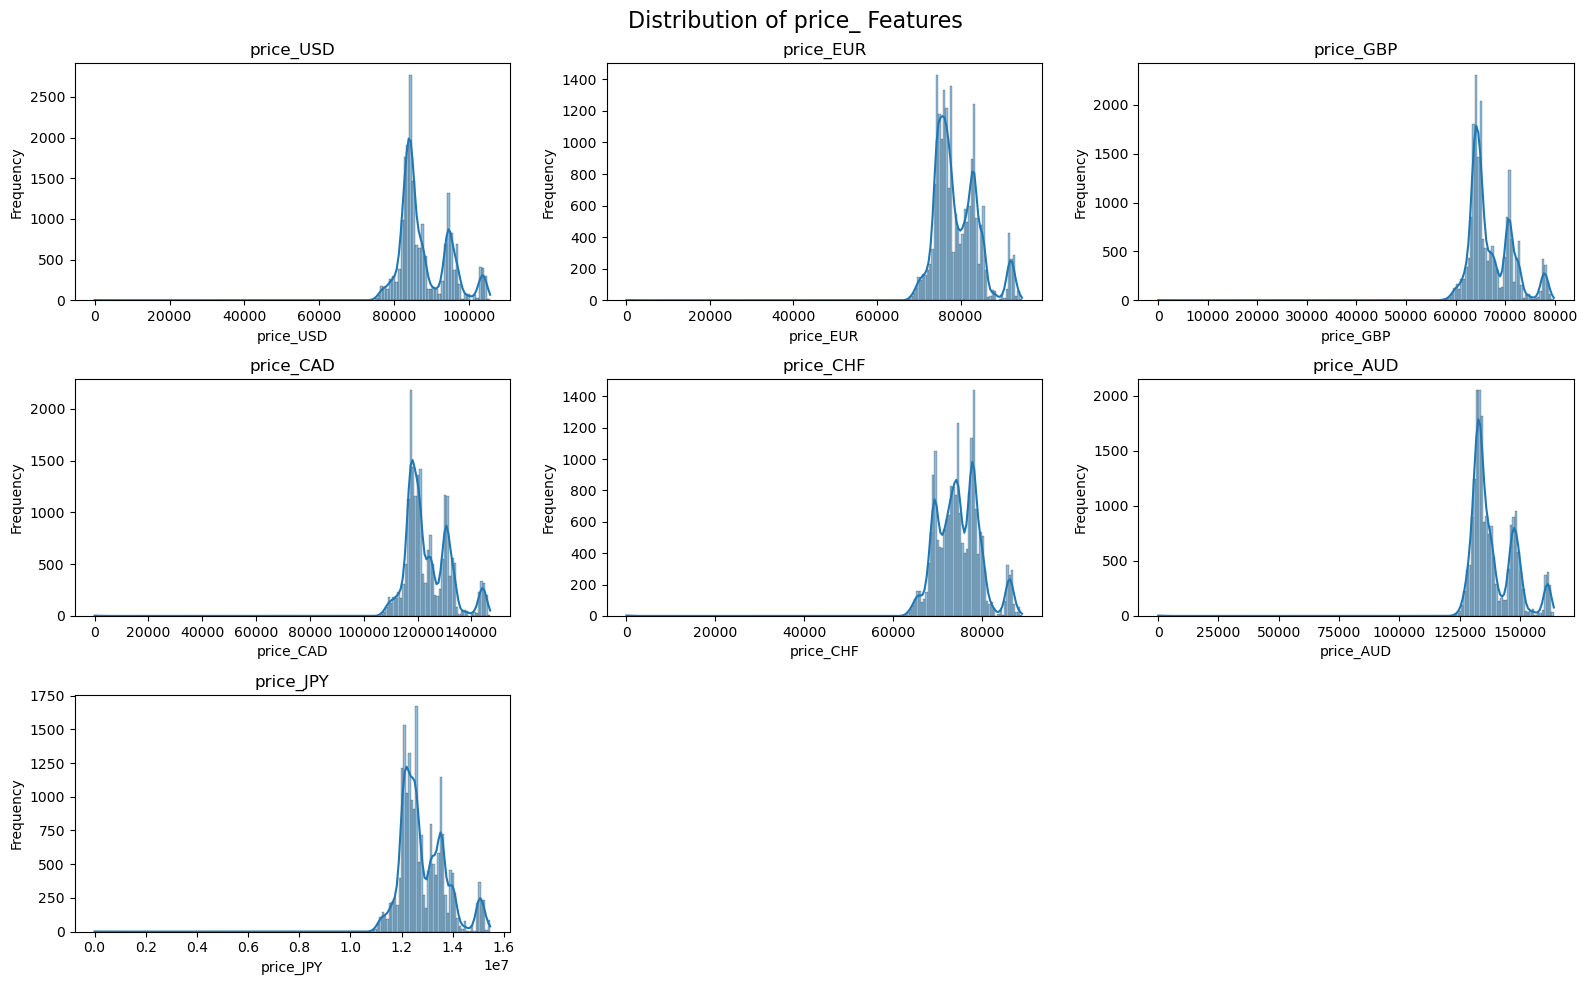

In [14]:
plot_feature_group(df, "price_")

#### Key Insights:
- All currency prices (`price_USD`, `price_EUR`, ...) cluster within narrow ranges and exhibit similar multi-modal patterns.
- This consistency reflects synchronized market behavior across currencies.
- Price features are relatively stable and can be used as external covariates without transformation.

### 5.6 Histogram Bin Features
Histogram bin features summarize how transactions are distributed across fee ranges. These bins reflect user behavior under different network conditions and can highlight preferred fee levels or congestion thresholds.

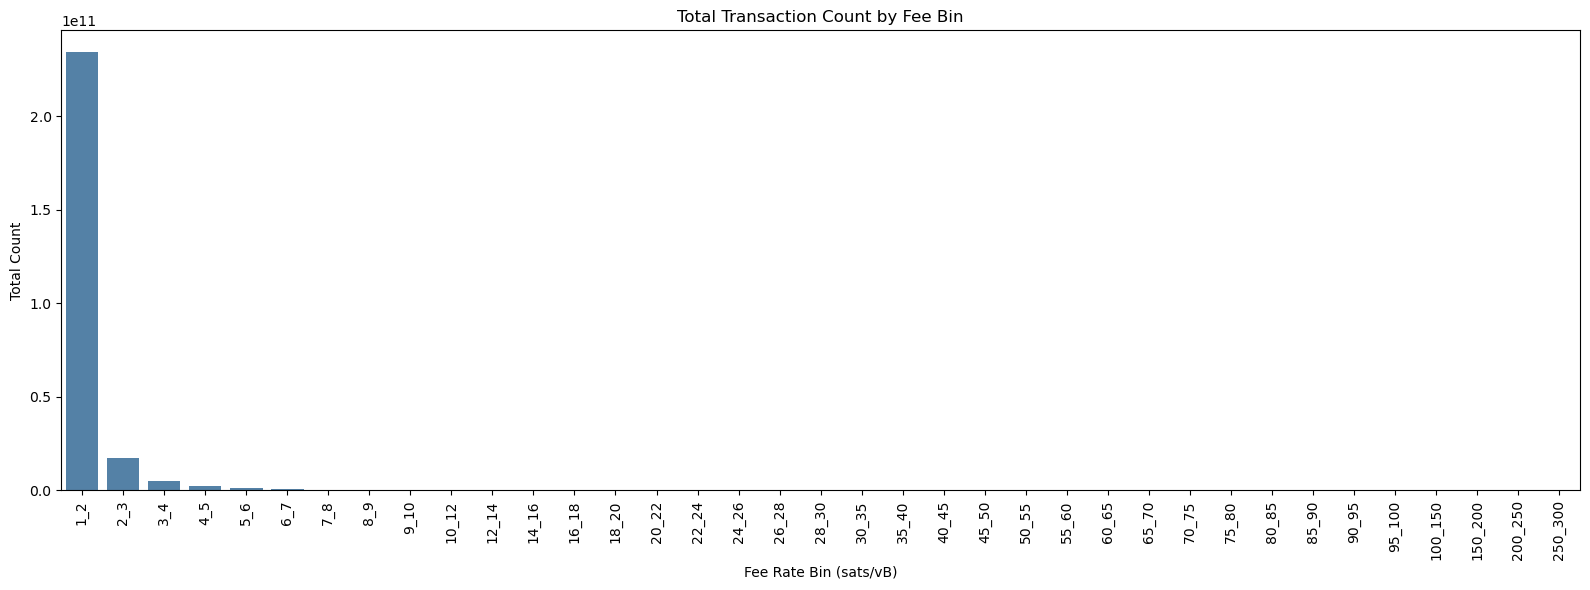

In [15]:
fee_cols = [col for col in df.columns if col.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()
def extract_start(bin_name):
    return float(bin_name.split("_")[-2])
total_per_bin = total_per_bin.sort_values(key=lambda x: [extract_start(c) for c in x.index])
bin_labels = [col.replace("mempool_fee_histogram_bin_", "") for col in total_per_bin.index]
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=total_per_bin.values, color="steelblue")
plt.xticks(rotation=90)
plt.title("Total Transaction Count by Fee Bin")
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("Total Count")
plt.tight_layout()
plt.show()


#### Key Insights:
- Roughly 92.5% of all transactions fall into the 1–2 sats/vB bin; including 2–3 sats/vB brings the cumulative share above 96%.
- Higher-fee bins are extremely sparse—consider merging rare bins or focusing only on the first few for modeling to reduce sparsity.

### 5.7 Fee Bin Proportions
To better understand the transaction volume distribution, we compute the relative proportion of total counts in each fee bin. This highlights where the majority of network activity is concentrated and informs feature engineering decisions.

In [16]:
# Calculate the proportion of each bin's count relative to the total count
total_count = total_per_bin.sum()
bin_proportions = total_per_bin / total_count * 100
bin_proportions.head()

mempool_fee_histogram_bin_1_2    88.918346
mempool_fee_histogram_bin_2_3     6.608440
mempool_fee_histogram_bin_3_4     1.889749
mempool_fee_histogram_bin_4_5     0.970637
mempool_fee_histogram_bin_5_6     0.553460
dtype: float64

#### Key Insights:
- Over **98%** of all transactions fall into the **0–5 sats/vB** range  
  (**88.9%** in 1–2, **6.6%** in 2–3, **1.9%** in 3–4, **1.0%** in 4–5 sats/vB)
- Bins above 5 sats/vB are extremely rare (**0.6%**) and could be aggregated or treated as “other” in downstream modeling to reduce sparsity.

### 5.8 Log-Scaled Fee Bin Counts
To better visualize transaction counts across a wide dynamic range, we apply a log transformation to the total count in each fee bin. This helps reveal patterns in the mid-to-high fee ranges that are otherwise overshadowed by the extreme skew toward low-fee transactions.

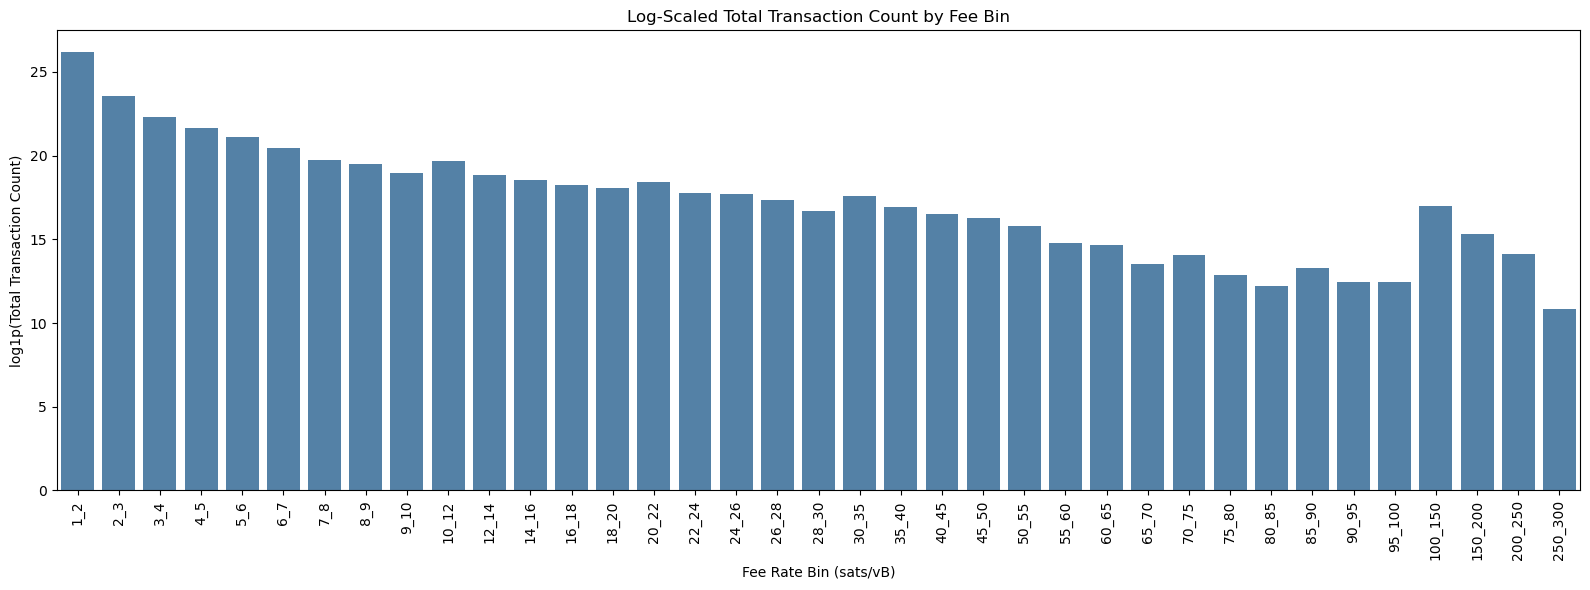

In [17]:
# Sum total transaction counts for each fee bin
fee_cols = [c for c in df.columns if c.startswith("mempool_fee_histogram_bin_")]
total_per_bin = df[fee_cols].sum()

# Extract numeric labels for plotting
bin_labels = [c.replace("mempool_fee_histogram_bin_", "") for c in total_per_bin.index]

# Apply log1p transformation to counts
log_counts = np.log1p(total_per_bin)

# Plot the log-scaled counts
plt.figure(figsize=(16, 6))
sns.barplot(x=bin_labels, y=log_counts.values, color="steelblue")
plt.xticks(rotation=90)
plt.xlabel("Fee Rate Bin (sats/vB)")
plt.ylabel("log1p(Total Transaction Count)")
plt.title("Log-Scaled Total Transaction Count by Fee Bin")
plt.tight_layout()
plt.show()

#### Key Insights:
- After applying the `log₁₀` transform, the dominance of the 1–2 sats/vB bin remains, but the decline across higher bins appears smoother.
- This reveals that although the vast majority of transactions occur at very low fees, there is meaningful activity extending up to around 20 sats/vB.
- Log transformation enables better visualization and may guide bin grouping or scaling decisions for downstream modeling.

## 6. Timestamp Coverage & Sampling

We check the overall time coverage and sampling interval of the dataset to evaluate temporal consistency.


In [18]:
print("Start:", df.index.min())
print("End:", df.index.max())
print("Frequency mode:", df.index.to_series().diff().mode())

Start: 2025-03-05 02:14:41
End: 2025-05-12 19:59:41
Frequency mode: 0   0 days 00:05:00
Name: timestamp, dtype: timedelta64[ns]


#### Key Insights:
- The dataset spans from **2025-03-05 02:14:41** to **2025-05-12 19:59:41**, covering over two months.
- The most frequent sampling interval is **5 minutes**, but intervals are not strictly regular.
- Many time series models (e.g., ARIMA, TFT, DeepAR) require **evenly spaced** observations—this suggests we may need to **reindex and interpolate** the data during preprocessing.

## 7. Trend and Seaonality of Fastest Fee

We explore the temporal structure of the target variable `recommended_fee_fastestFee` to identify possible long-term trends and short-term seasonality patterns.

To match the model input format, we use a 5-minute resampled time series, with daily periodicity (`period=288`).

### 7.1 Additive Decomposition of Target Feature
To analyze the temporal structure of the target fee rate, we apply an additive seasonal decomposition on the 5-minute resampled `recommended_fee_fastestFee` series. This helps us isolate the long-term trend, recurring daily seasonality, and residual noise or anomalies. We use a daily cycle of 288 intervals (since 288 × 5 minutes = 1 day) to reflect typical usage behavior over a day.


In [24]:
def plot_decomposition_custom(series, model, period, title, save_path=None, figsize=(10, 6)):
    """
    Decompose a time series and plot trend, seasonality, and residuals.

    Parameters
    ----------
    series : pd.Series
        Time series to decompose (indexed by datetime).
    model : str
        Decomposition model: 'additive' or 'multiplicative'.
    period : int
        Seasonal period (e.g., 288 = 1 day at 5-min intervals, 96 = 1 day at 15-min).
    title : str
        Plot title.
    save_path : str or None, optional
        File path to save the figure. If None, figure is not saved.
    figsize : tuple, optional
        Size of the figure.

    Returns
    -------
    None
        Displays the decomposition plot.
    """
    series = series.copy()
    series.name = ""
    
    result = seasonal_decompose(series, model=model, period=period)
    fig = result.plot()
    fig.set_size_inches(figsize)

    # Format x-axis (weekly ticks, 'Jun 01' format)
    for ax in fig.axes:
        ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

    # Label first and last subplot
    fig.axes[0].set_ylabel("Distribution")
    fig.axes[-1].set_xlabel("Date")
    fig.suptitle(title, y=1.02)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


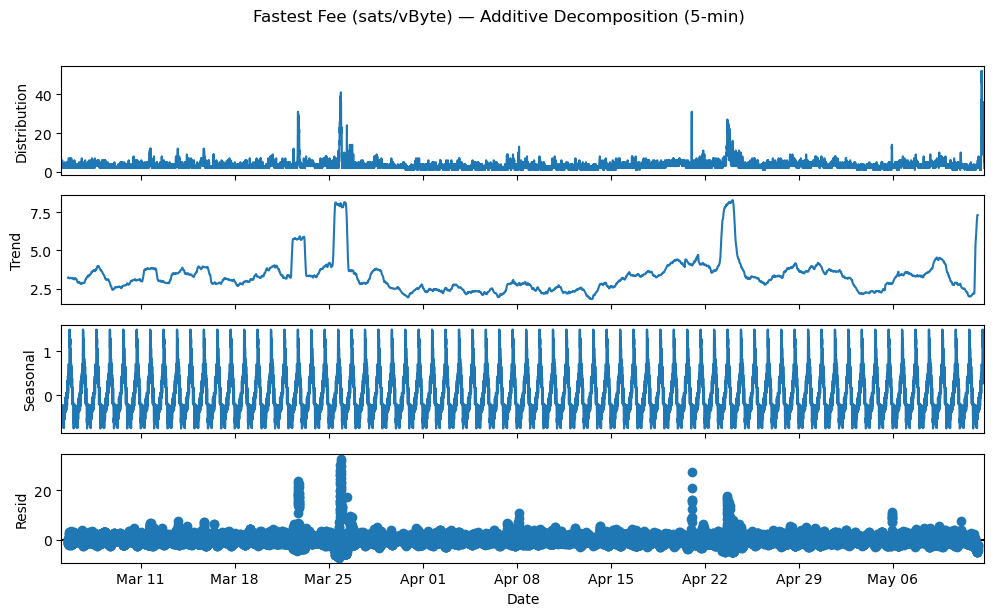

In [25]:
# Use 5-minute resampled data
# period=288 means 288 5-minute intervals = 1 day
plot_decomposition_custom(
    series=df["recommended_fee_fastestFee"],
    model="additive",
    period=288,
    title="Fastest Fee (sats/vByte) — Additive Decomposition (5-min)"
)

#### Key Insights:
- The trend component shows a gradual increase and several demand-driven spikes, indicating changing network conditions over time.
- A strong daily pattern is evident in the seasonal component, confirming the presence of short-term cyclic behavior in fee dynamics.
- The residual captures localized anomalies around March 22–25 and early April, suggesting short-lived congestion events.
- This decomposition validates the presence of both trend and seasonality, supporting their inclusion in forecasting models.

### 7.2 Multiplicative Decomposition of Target Feature
To further analyze the temporal structure of the `recommended_fee_fastestFee` series, we apply a **multiplicative seasonal decomposition**. This approach assumes that trend, seasonality, and residuals multiply together rather than add, which is more appropriate when seasonal fluctuations increase with the level of the series. The period is set to 288, corresponding to one day of 5-minute intervals.


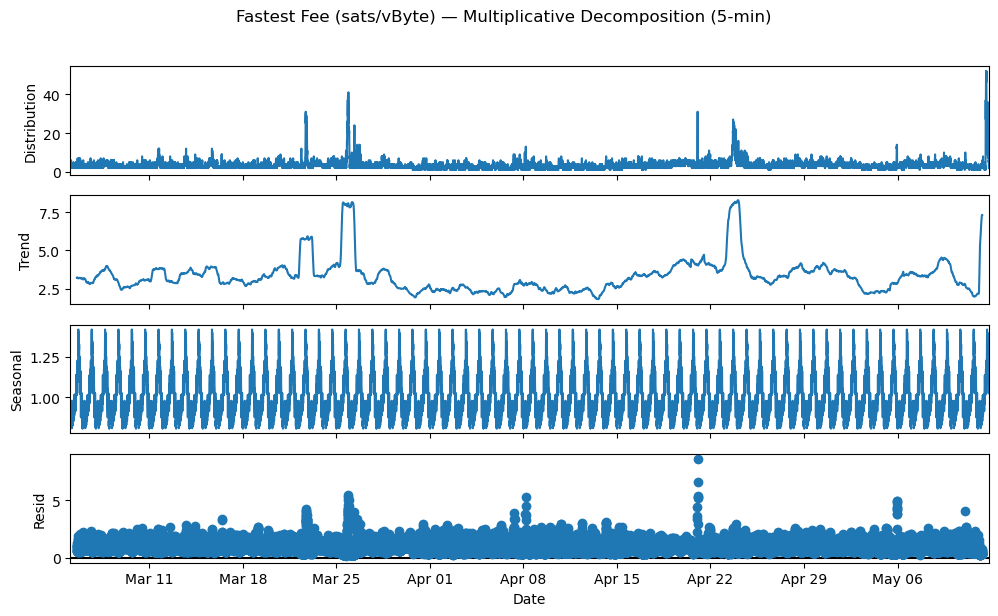

In [26]:
# Multiplicative decomposition using daily periodicity (288 intervals = 24 hours)
plot_decomposition_custom(
    series=df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288,
    title="Fastest Fee (sats/vByte) — Multiplicative Decomposition (5-min)",
    save_path="../img/decomposition_multiplicative.png"
)

#### Key Insights:
- A **daily seasonality pattern** with stable oscillations is observed, confirming 24-hour trading cycles.
- The **trend component** shows a nonlinear rise and a temporary spike in late March, indicating possible congestion events.
- **Significant residual spikes** suggest anomalies or sudden traffic surges that cannot be explained by regular patterns.
- This supports using time series models that account for both **seasonality** and **event-driven effects**, such as Prophet or DeepAR.

### 7.3 Residual Diagnostics

We examine the residuals to assess whether the residual component from the multiplicative decomposition contains meaningful autocorrelation structure or is just random noise. 
We focus on the multiplicative version because it better captures the proportional seasonal variation in the data.  
Additive residuals are not analyzed further, as multiplicative decomposition is more appropriate for our scale and volatility.

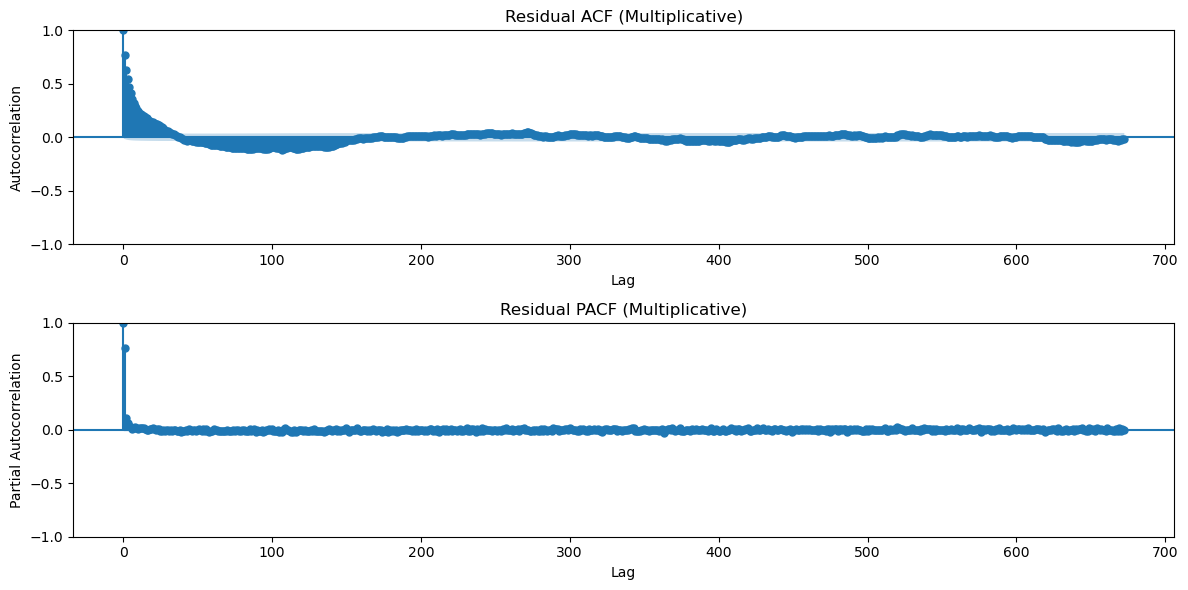

In [33]:
decomp_result_mul = seasonal_decompose(
    df["recommended_fee_fastestFee"],
    model="multiplicative",
    period=288
)

residuals = decomp_result_mul.resid.dropna()

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(residuals, ax=ax[0], lags=672, title='Residual ACF (Multiplicative)')
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("Autocorrelation")
plot_pacf(residuals, ax=ax[1], lags=672, title='Residual PACF (Multiplicative)')
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("Partial Autocorrelation")
plt.tight_layout()
plt.show()

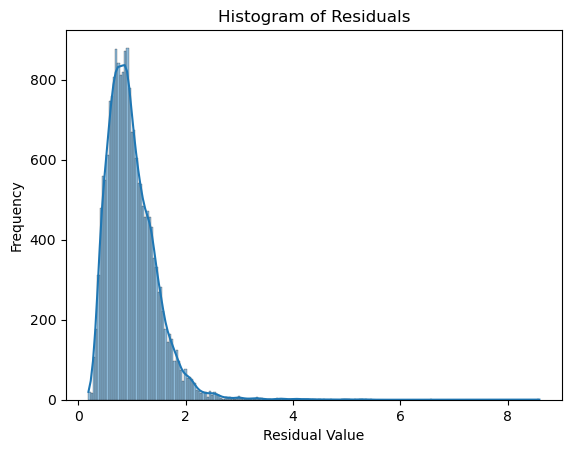

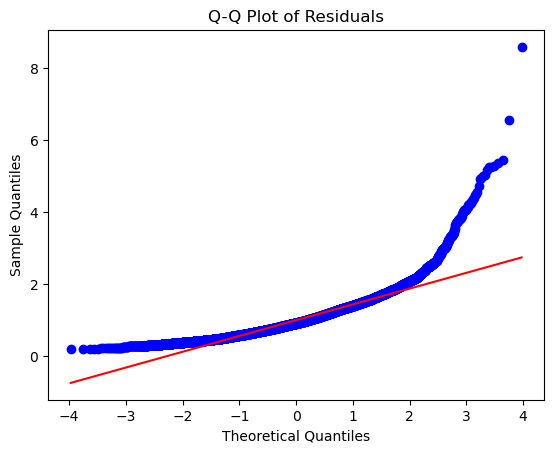

In [34]:
# Histogram
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel("Residual Value") 
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()

#### Key Insights:

- **ACF and PACF plots** show a slow decay rather than an immediate drop, indicating that the residual component still contains short-term autocorrelation.
- **Histogram and Q–Q plot** show that the residuals are right-skewed and deviate from a normal distribution, especially in the tails.

These findings suggest that the residuals are not purely white noise, and may still contain useful signal.  
Therefore, further investigation—such as segmenting residuals by date or incorporating them into a hybrid modeling approach—may be warranted.

We segment the residuals from the multiplicative decomposition by week to explore whether volatility or anomalies concentrate in specific time periods. This helps reveal modeling gaps, outlier episodes, or structural shifts.

In [35]:
# Extract residuals from multiplicative decomposition
residuals = decomp_result_mul.resid.dropna().to_frame(name='resid')

# Create custom week index from timestamp
start_time = residuals.index.min()
residuals['week'] = ((residuals.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Calculate summary stats per week
resid_stats = residuals.groupby('week')['resid'].describe()[['mean', 'std', 'min', 'max']]
display(resid_stats)


,mean,std,min,max
week,,,,
1,1.004249,0.390378,0.446884,2.650531
2,0.988730,0.382693,0.429432,3.331140
3,0.985712,0.644304,0.187176,5.443981
4,1.001817,0.437904,0.322742,2.953958
5,0.987337,0.536003,0.274949,5.255659
6,0.998457,0.491815,0.303353,3.095364
7,0.990312,0.453113,0.295467,8.589596
8,1.013908,0.409304,0.357552,2.922803
9,1.006077,0.442597,0.284087,4.953548


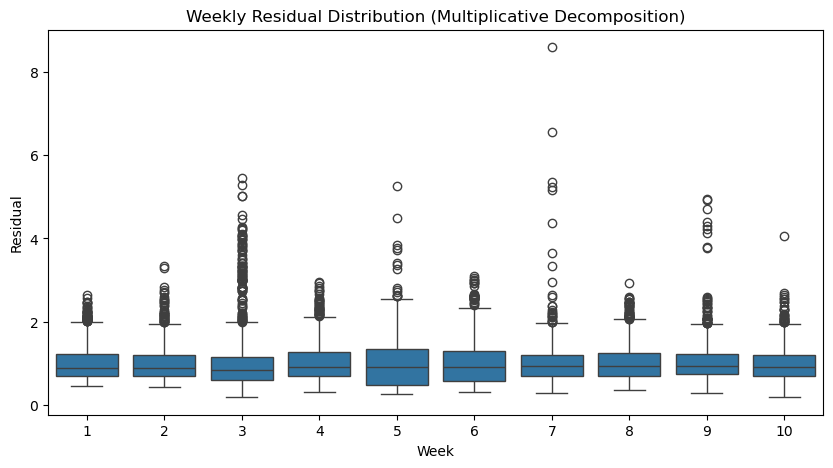

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=residuals, x='week', y='resid')
plt.title('Weekly Residual Distribution (Multiplicative Decomposition)')
plt.ylabel('Residual')
plt.xlabel('Week')
plt.show()

#### Key Insights:

- **Week 3** exhibits the highest residual volatility, with the largest standard deviation (0.64) and a local residual maximum of 5.44. This suggests potential model underfit or unmodeled behavior.
- **Week 5** also shows elevated dispersion and high residual values, supporting the idea of recurring volatility or underperformance.
- **Week 7** contains the most extreme single outlier (residual > 8.5), which may point to an unmodeled event or structural issue.

These results show that residual variance is not uniformly distributed over time, and motivate further refinement of the model to account for time-varying behavior or external shocks.

### 7.4 Weekly Seasonality Decomposition

To further explore longer-term cyclic behavior, we decomposed the fastest fee series using a 7-day seasonal period (2016 intervals based on 5-minute sampling). This allows us to inspect whether weekly patterns—such as weekday vs. weekend congestion—are present in the data.

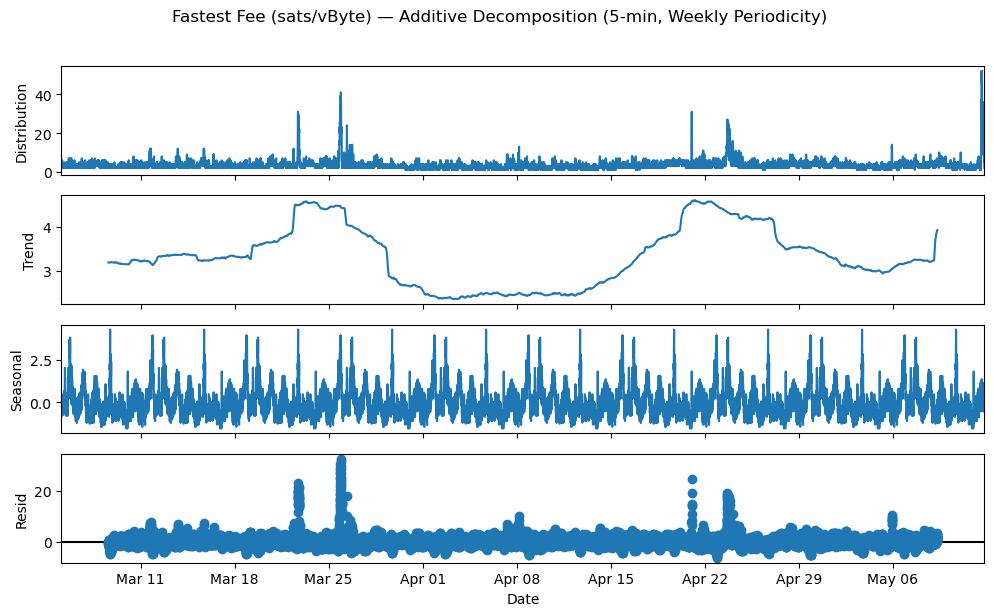

In [37]:
plot_decomposition_custom(
    series=df["recommended_fee_fastestFee"],
    model="additive",
    period=2016,
    title="Fastest Fee (sats/vByte) — Additive Decomposition (5-min, Weekly Periodicity)"
)

**Insight:**

- The **trend component** shows alternating rise and fall segments across the study period, reflecting medium-term shifts in average transaction fee levels.
- The **seasonal component** contains repeated local fluctuations but does not exhibit a consistently strong weekly pattern. The spikes appear irregular and noisy, suggesting only weak or unstable weekly seasonality.
- **Residuals remain volatile**, with multiple sharp spikes—especially in the middle weeks—indicating periods of unusual behavior or modeling gaps.

Overall, while some weekly patterns may be present, they are overshadowed by noise and residual volatility, limiting the strength of weekly seasonality in the data.


## 8. Stationarity Checks of Target Feature

To build effective forecasting models for the target variable `recommended_fee_fastestFee`, it is essential to understand whether the series is stationary—that is, whether its mean and variance remain stable over time. Many classical models such as ARIMA rely on this assumption.

Given the known volatility and occasional spikes in fee values, we use both visual tools and statistical tests to evaluate stationarity. This helps determine whether transformations (e.g., differencing) or alternative models are needed to capture the underlying dynamics.


### 8.1 Rolling Mean and Standard Deviation

We plot the rolling mean and standard deviation of the target feature to visually assess stationarity. A stationary series should have relatively constant mean and variance over time.

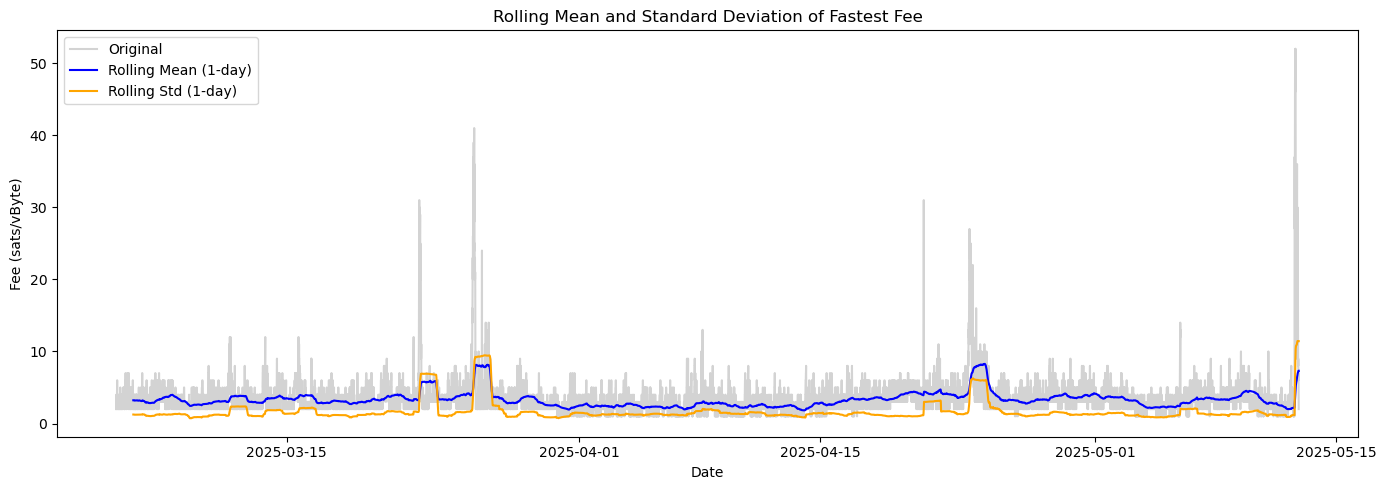

In [38]:
window = 288  # 1-day window for 5-min data

rolling_mean = df["recommended_fee_fastestFee"].rolling(window=window).mean()
rolling_std = df["recommended_fee_fastestFee"].rolling(window=window).std()

plt.figure(figsize=(14, 5))
plt.plot(df["recommended_fee_fastestFee"], color="lightgray", label="Original")
plt.plot(rolling_mean, color="blue", label="Rolling Mean (1-day)")
plt.plot(rolling_std, color="orange", label="Rolling Std (1-day)")
plt.title("Rolling Mean and Standard Deviation of Fastest Fee")
plt.xlabel("Date") 
plt.ylabel("Fee (sats/vByte)")
plt.legend()
plt.tight_layout()
plt.show()

The plot shows:

- The rolling mean (blue) and rolling standard deviation (orange) both exhibit meaningful variation over time, indicating the series is not strictly stationary.

- Two distinct periods of increased volatility are visible:
  - The first occurs around **March 22–25**, where both rolling mean and std rise sharply, suggesting a short-term spike in fees.
  - The second occurs in **early May**, marked by a similar surge in both metrics and several sharp fee spikes in the raw series.

These shifts suggest non-stationarity in both the mean and variance of the series, which suggests that a formal **Augmented Dickey-Fuller (ADF) test** is needed to confirm non-stationarity and decide whether preprocessing steps such as differencing are required.

### 8.2 Augmented Dickey-Fuller (ADF) Test

We perform the Augmented Dickey-Fuller (ADF) test to assess the stationarity of the `recommended_fee_fastestFee` series. Understanding whether the series is stationary helps inform the choice of appropriate modeling techniques in subsequent steps.


In [39]:
# Perform ADF test on the target feature
adf_result = adfuller(df["recommended_fee_fastestFee"].dropna())

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -14.95910281462677
p-value: 1.2472595480007128e-27
Critical Value (1%): -3.4307
Critical Value (5%): -2.8617
Critical Value (10%): -2.5668


#### Key Insights:

The ADF test result shows a test statistic of **-14.96**, which is significantly lower than all critical values at the 1%, 5%, and 10% levels.  
The p-value is effectively zero (**1.25e-27**), providing strong evidence to reject the null hypothesis of non-stationarity.

This suggests that the `recommended_fee_fastestFee` series is **statistically stationary when assessed over the entire period**.

However, as observed in the rolling mean and seasonal decomposition plots, the series exhibits **localized volatility spikes** and **temporary structural shifts**.  
These fluctuations are not captured by the global ADF test, which motivates further investigation in Section 8.3 to assess **local or segment-wise stationarity**.

### 8.3 Week-by-Week Stationarity Analysis
We segment the dataset into weekly chunks (2016 rows per week based on 5-minute intervals) and run the Augmented Dickey-Fuller (ADF) test separately on each chunk.  
This allows us to examine **short-term local stationarity**, helping detect temporal shifts, modeling instabilities, or unexpected bursts in fee dynamics.  
If any week's p-value greater than significance level, it would indicate **non-stationarity**, prompting further segmentation or modeling adjustments.

In [40]:
# Create custom weekly index
start_time = df.index.min()
df['custom_week'] = ((df.index - start_time) / pd.Timedelta(days=7)).astype(int) + 1

# Get max available full weeks
max_week = df['custom_week'].max()

# Run ADF for each week
results = []

for week in range(1, max_week):
    series = df[df['custom_week'] == week]['recommended_fee_fastestFee'].dropna()
    if len(series) >= 50:
        p_val = adfuller(series)[1]
        results.append({'week': week, 'p_value': p_val})
    else:
        results.append({'week': week, 'p_value': None})

weekly_adf_df = pd.DataFrame(results)
weekly_adf_df['p_value'] = weekly_adf_df['p_value'].apply(
    lambda x: f"{x:.4e}" if pd.notnull(x) else "Insufficient Data"
)

display(weekly_adf_df)

,week,p_value
0,1,5.0183e-10
1,2,4.8604e-10
2,3,6.1720e-09
3,4,1.2239e-05
4,5,4.2756e-09
5,6,1.3445e-12
6,7,1.0003e-24
7,8,3.7207e-04
8,9,8.4836e-20


Note: We excluded the final few days of the dataset from the week-by-week ADF test because they do not form a complete 7-day window (i.e., fewer than 2016 5-minute intervals). Including an incomplete segment could produce unreliable test statistics due to insufficient sample size.

#### Key Insights:

Each of the ten 7-day segments shows a **p-value well below** the 1%, 5%, and 10% critical thresholds, confirming that the target series is **locally stationary** throughout.

Combined with Section 8.2's global ADF result, we conclude that the `recommended_fee_fastestFee` series is **statistically stationary both overall and within short-term windows**.

This validation supports the use of models that assume stationarity—such as **SARIMA, or seasonal ML models**—without needing differencing or structural fixes.

## 9. Optimal Sampling Interval for Modeling

### 9.1 Determine the Optimal Sampling Interval
To determine the most suitable sampling interval for modeling, we examine the partial autocorrelation (PACF) structure of the `recommended_fee_fastestFee` target variable across different resampled intervals. A good interval should retain strong short-term signal (PACF lag-1) while minimizing noise and oversmoothing.

We compute:

- **PACF at lag 1**: Indicates short-term dependence.  
- **PACF at lag 2**: Helps assess decay and oversmoothing.  
- **Decay ratio (|lag1| / |lag2|)**: Larger values suggest sharper signal decay and better AR model compatibility.

,frequency,pacf_lag1,pacf_lag2,decay_ratio
0,5min,0.920,0.122,7.54
1,10min,0.905,0.054,16.89
2,15min,0.892,0.010,89.96
3,20min,0.872,-0.016,52.87
4,30min,0.845,-0.127,6.67
5,1h,0.750,-0.162,4.64


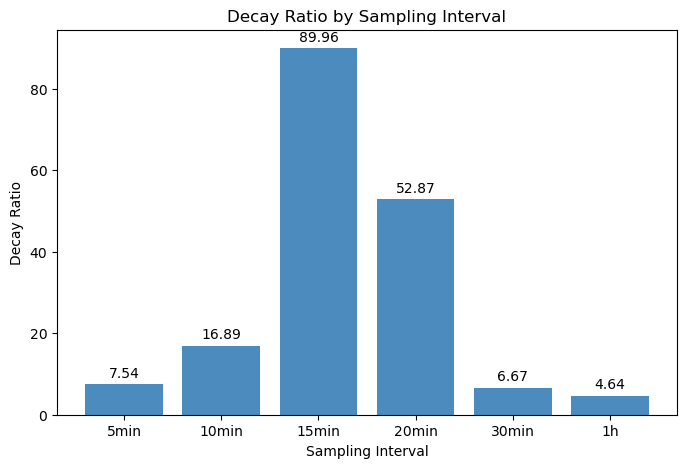

In [41]:
freqs = ['5min', '10min', '15min', '20min', '30min', '1h']
results = []

for freq in freqs:
    # Resample and drop NA
    resampled = df['recommended_fee_fastestFee'].resample(freq).mean().dropna()

    # Compute PACF up to lag 5
    pacf_vals = pacf(resampled, nlags=5, method='yw')

    # Safety check
    if len(pacf_vals) >= 3:
        lag1 = pacf_vals[1]
        lag2 = pacf_vals[2]
        decay_ratio = abs(lag1) / abs(lag2) if lag2 != 0 else float('inf')

        results.append({
            'frequency': freq,
            'pacf_lag1': round(lag1, 3),
            'pacf_lag2': round(lag2, 3),
            'decay_ratio': round(decay_ratio, 2)
        })

interval_eval_df = pd.DataFrame(results)
display(interval_eval_df.sort_values(by='pacf_lag1', ascending=False))

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.bar(interval_eval_df['frequency'], interval_eval_df['decay_ratio'], color='#4B8BBE')

plt.title('Decay Ratio by Sampling Interval')
plt.ylabel('Decay Ratio')
plt.xlabel('Sampling Interval')

# Annotate bars
for i, val in enumerate(interval_eval_df['decay_ratio']):
    plt.text(i, val + 1, f'{val:.2f}', ha='center', va='bottom', fontsize=10)

plt.savefig('../img/optimal_interval.png', dpi=300, bbox_inches='tight')
plt.show()

#### Key Insights:

- All intervals show strong lag-1 PACF (≥ 0.75), confirming short-term predictability exists across resolutions.  
- The **10-minute interval** shows the strongest lag-1 signal (0.905) and a small lag-2 (0.054), resulting in a high decay ratio (~17).  
- The **15-minute interval** has a slightly weaker lag-1 (0.892) and nearly zero lag-2 (0.010), leading to the **highest decay ratio (~90)**, suggesting excellent signal clarity with minimal noise.  
- Longer intervals like **30min** and **1h** produce negative or unstable lag-2 PACF, indicating possible oversmoothing or structural distortion.  
- The **20-minute interval** also yields a negative decay ratio due to lag-2 ≈ 0, reducing its reliability for modeling.

We therefore recommend using a **15-minute sampling interval** for downstream modeling, as it balances short-term signal clarity and stability without introducing volatility from noise or loss of structure due to oversmoothing.

### 9.2 Daily Seasonality in 15-Minute Resampled Data

To support the selection of appropriate seasonal parameters for SARIMA and other time series models, we analyze whether the 15-minute resampled data exhibits clear daily seasonality or long-term trends.  
We apply seasonal decomposition with a daily periodicity of 96 (15-minute intervals × 96 = 24 hours).

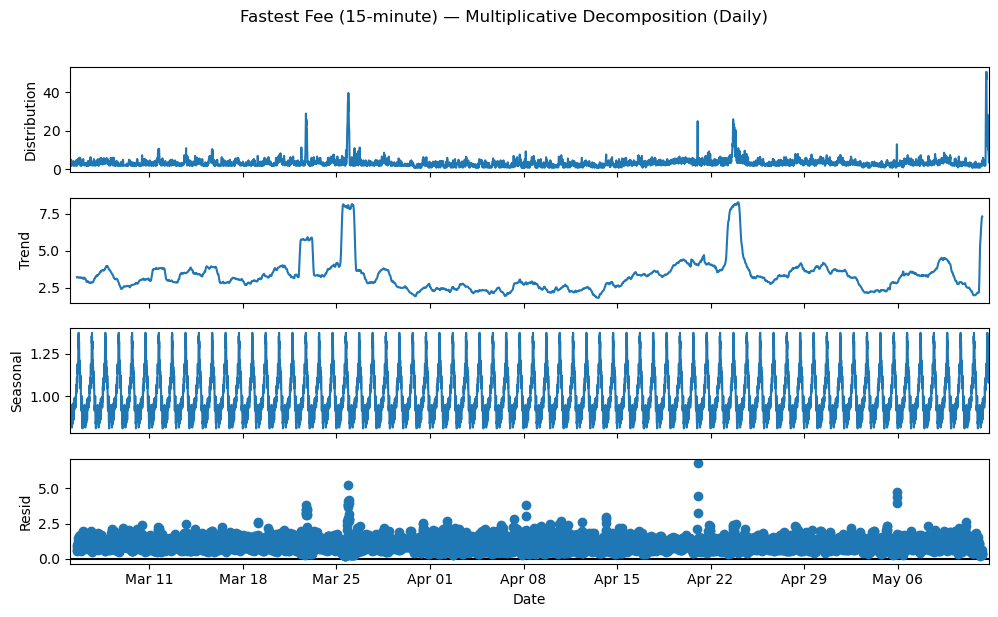

In [42]:
# Resample to 15-minute intervals
df_15min = df['recommended_fee_fastestFee'].resample('15min').mean().dropna()

# Perform seasonal decomposition (1-day = 96 intervals)
plot_decomposition_custom(
    series=df_15min,
    model="multiplicative",
    period=96,
    title="Fastest Fee (15-minute) — Multiplicative Decomposition (Daily)"
)

#### Key Insights:
- The **seasonal component** shows consistent daily cycles with aligned peaks and troughs, confirming a strong 24-hour behavioral rhythm across the dataset.
- The **trend component** captures multi-day shifts and fee level changes, including pronounced spikes around late March and early May—previously identified as congestion periods.
- The **residual component** remains small and mostly noisy, except during these volatility spikes, indicating that most structure is captured by the seasonal and trend components.

These findings validate the use of a **daily seasonal period (s = 96)** in downstream modeling such as SARIMA, where incorporating this seasonality is expected to improve predictive accuracy and reduce residual variance.

### 9.3 Weekly Seasonal Structure in 15-Minute Data

To investigate whether longer-term weekly cycles are present in the resampled data, we apply seasonal decomposition using a weekly periodicity of 672 (15-minute intervals × 7 days).

This analysis will help determine whether SARIMA models should include weekly seasonal components.

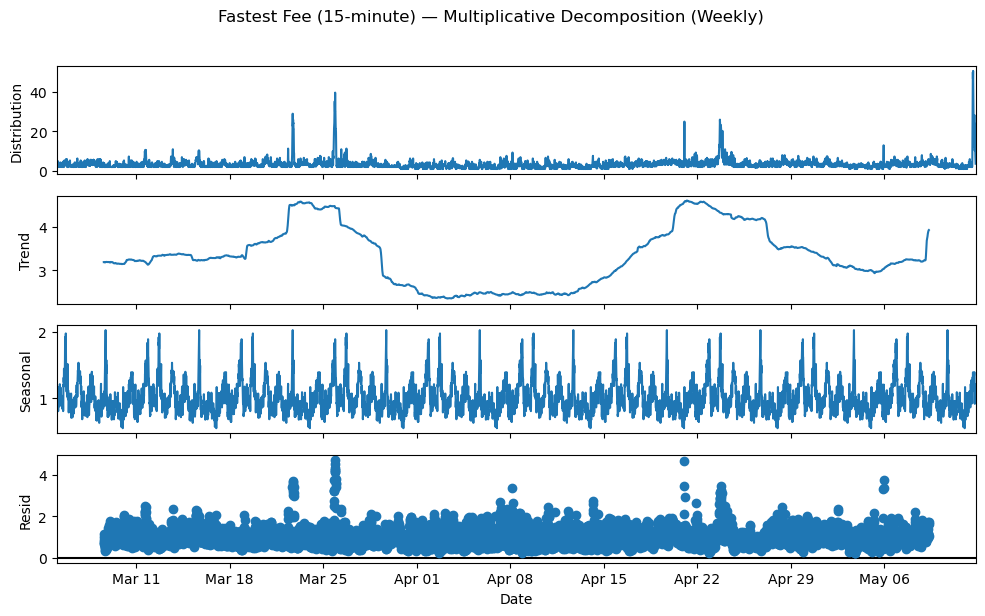

In [43]:
# Weekly periodicity: 15min × 672 = 1 week
plot_decomposition_custom(
    series=df_15min,
    model="multiplicative",
    period=672,  # 15min × 672 = 1 week
    title="Fastest Fee (15-minute) — Multiplicative Decomposition (Weekly)"
)

#### Key Insights:

- The seasonal decomposition with weekly periodicity (`s = 672`) does not reveal a consistent or clearly repeating weekly pattern.
- The seasonal component appears noisy and may be overshadowed by the stronger and more stable daily cycles observed earlier.
- This suggests that a **weekly seasonal structure is not strongly supported** in the current data and is likely unnecessary for SARIMA or related models.

We will therefore proceed with **daily seasonality only (`s = 96`)** for downstream modeling.

### 9.4 Autocorrelation and Partial Autocorrelation in 15-Minute Data

Understanding the autocorrelation structure of the time series is critical for selecting appropriate forecasting models.  
- The **Autocorrelation Function (ACF)** helps us assess whether and how current values depend on past values across various lags.
- The **Partial Autocorrelation Function (PACF)** helps us determine the order of autoregressive (AR) components needed in the model.

By analyzing ACF and PACF, we can decide whether autoregressive models (such as ARIMA or SARIMA) are suitable and how many lag terms to include.

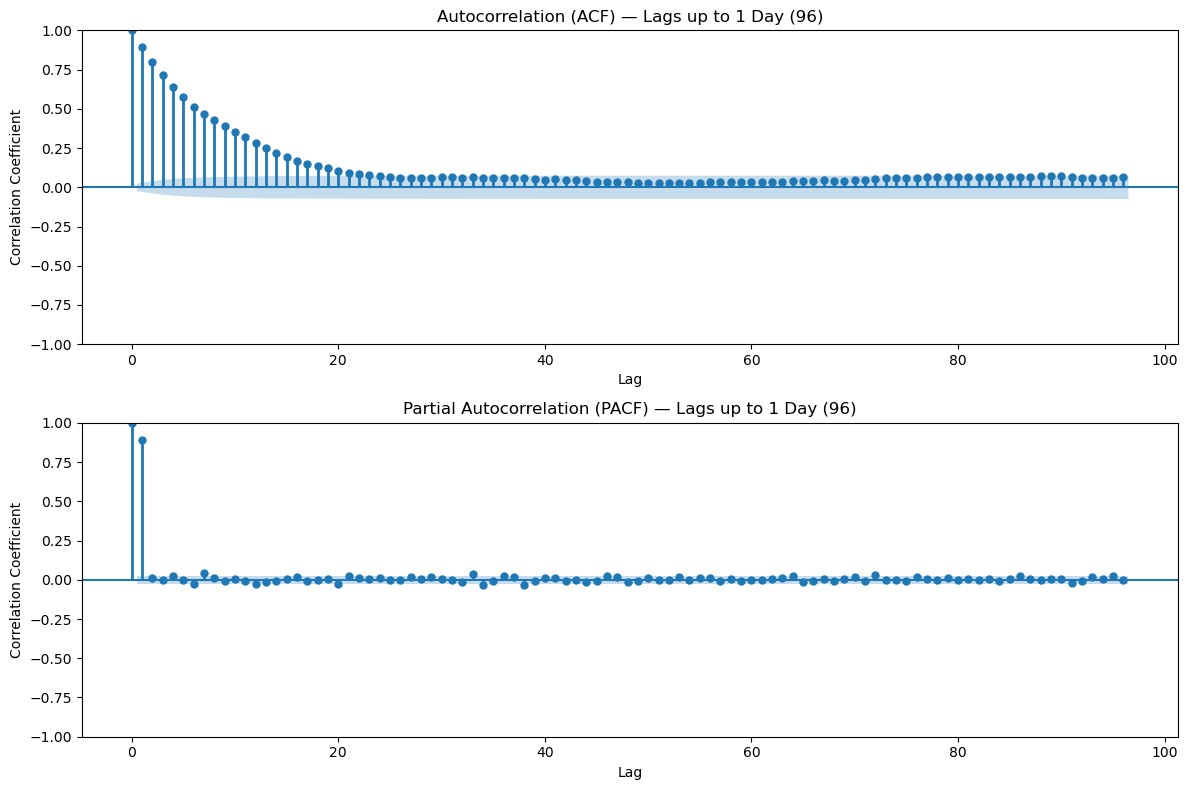

In [44]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot ACF
plot_acf(
    df_15min,  
    lags=96, 
    ax=axes[0],
    vlines_kwargs={'colors': 'C0', 'linestyles': '-', 'linewidth': 2},
    alpha=0.05
)
axes[0].set_ylim(-1, 1)
axes[0].set_title("Autocorrelation (ACF) — Lags up to 1 Day (96)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Correlation Coefficient")

# Plot PACF
plot_pacf(
    df_15min,  
    lags=96, 
    ax=axes[1],
    vlines_kwargs={'colors': 'C0', 'linestyles': '-', 'linewidth': 2},
    alpha=0.05
)
axes[1].set_ylim(-1, 1)
axes[1].set_title("Partial Autocorrelation (PACF) — Lags up to 1 Day (96)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Correlation Coefficient")

plt.tight_layout()
plt.savefig("../img/acf_pacf_plot.png", dpi=300, bbox_inches="tight")
plt.show()

**Key Insights:**  
- The ACF plot shows **strong autocorrelation at short lags**, which gradually decays and oscillates around zero. This indicates clear **temporal dependence** in the data and supports the use of autoregressive models.
- The PACF plot exhibits a **sharp drop after lag 1**, suggesting that an **AR(1)-like structure** is appropriate for capturing most of the direct temporal dependencies.
- These patterns confirm that models incorporating autoregressive terms (e.g., ARIMA or SARIMA) are well-suited to model the dynamics of Bitcoin transaction fees at the 15-minute level.

### 9.5 Daily vs Weekly ACF Comparison

To visually contrast daily and weekly autocorrelation patterns, we compare the ACF of the 15-minute resampled series at two lag scales:

- **ACF with lags = 672 (≈ 7 days):** Highlights daily structure, with strong peaks every ~96 lags.
- **ACF with lags = 3360 (≈ 5 weeks):** Used to examine whether weekly structure (lag ≈ 672) is stable and repeated.

We focus on ACF only (not PACF) here because our goal is to inspect repeated cyclical autocorrelation—a hallmark of seasonal structure. PACF is more relevant for identifying short-term lag cutoffs in autoregressive modeling and has already been addressed in earlier sections.

The 5-week window ensures we cover at least 4 complete weekly cycles, offering enough resolution to identify whether autocorrelation peaks recur at multiples of 672 lags (i.e., weekly lags).


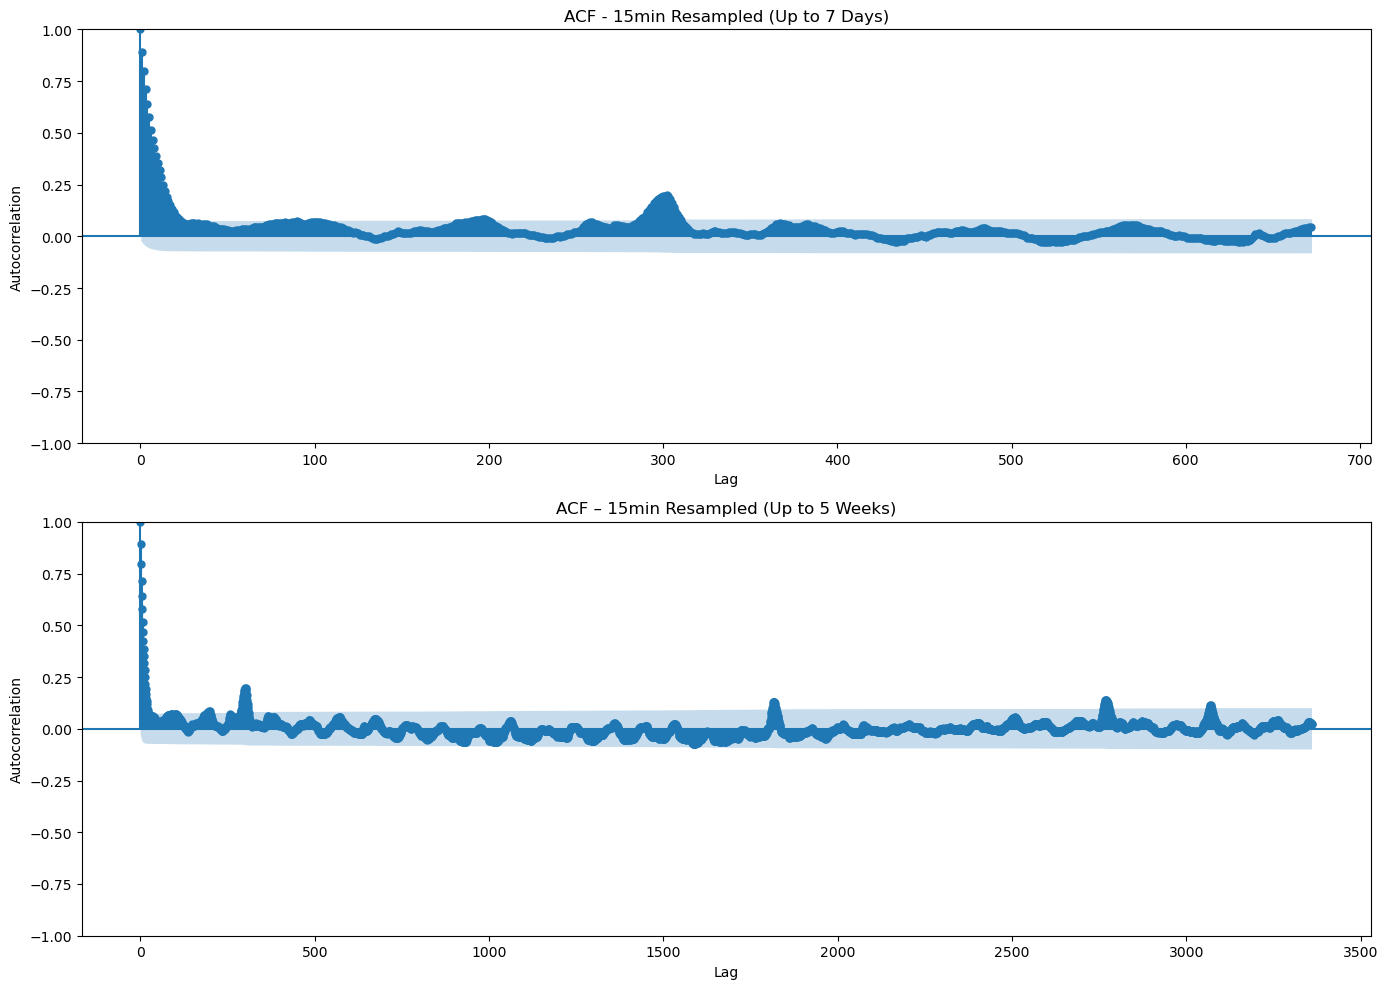

In [45]:
# Set figure size
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Daily scale: 672 lags (~7 days for 15min interval)
plot_acf(df_15min, lags=672, ax=axes[0])
axes[0].set_title("ACF - 15min Resampled (Up to 7 Days)")
axes[0].set_xlabel("Lag")
axes[0].set_ylabel("Autocorrelation")

# Weekly scale: 3360 lags (~5 weeks for 15min interval)
plot_acf(df_15min, lags=3360, ax=axes[1])
axes[1].set_title("ACF – 15min Resampled (Up to 5 Weeks)")
axes[1].set_xlabel("Lag")
axes[1].set_ylabel("Autocorrelation")

plt.tight_layout()
plt.show()


#### Key Insights:

- In the **7-day ACF**, a strong autocorrelation peak appears at lag ≈ 96 (i.e., 1 day), confirming clear **daily seasonality**. A smaller bump around lag 288–300 suggests **partial weekend effects**, though not consistently repeated.
- In the **5-week ACF**, no consistent peaks are observed at multiples of 672 (i.e., weekly lags), and the autocorrelation gradually decays beyond ≈ 500 lags. This indicates **no stable or recurring weekly autocorrelation** in the series.
- The absence of consistent long-lag patterns supports the conclusion that the series is **driven by daily cycles**, and **weekly effects are either weak or too irregular to model directly**.
- We will therefore proceed with **daily seasonal modeling** (e.g., `seasonal_period = 96`) in SARIMA or other time series frameworks.


## 10. Correlation Heatmap

### 10.1 Group-wise Feature Correlation Heatmaps
We analyze within-group correlations to detect redundancy or identify clusters of strongly related features before modeling.

In [46]:
group_prefixes = {
    # "mempool_blocks": "mempool_blocks_",
    "recommended_fee": "recommended_fee_",
    "mempool": "mempool_",
    "difficulty_adjustment": "difficulty_adjustment_",
    "price": "price_"
}
excluded_prefixes = ["mempool_fee_histogram_"]
def plot_group_correlation(df, group_name, prefix, exclude_prefixes=None):
    """
    Plots a heatmap of pairwise correlations among features in a specified group.

    Parameters:
        df (pd.DataFrame): The full dataset containing all features.
        group_name (str): A label for the feature group, used in the plot title.
        prefix (str): Prefix string used to identify relevant feature columns.
        exclude_prefixes (list of str, optional): List of prefixes to exclude from the correlation analysis.

    Notes:
        - Features are selected by matching the provided prefix.
        - If less than 2 valid features remain after exclusion, the plot is skipped.
        - Correlation is computed using pairwise Pearson correlation.
        - Feature labels with prefix 'difficulty_adjustment_' are shortened to 'diff_adj_' in the plot.
    """

    # Select columns matching prefix
    group_cols = [col for col in df.columns if col.startswith(prefix)]
    
    # Exclude anything that starts with excluded prefixes
    if exclude_prefixes:
        group_cols = [col for col in group_cols if not any(col.startswith(ex) for ex in exclude_prefixes)]

    # Drop NA for correlation
    group_df = df[group_cols].dropna()

    # Skip if not enough features
    if len(group_cols) < 2:
        print(f"Skipping group '{group_name}' — fewer than 2 valid columns.")
        return

    # Compute correlation
    corr = group_df.corr()

    # Shorten columns that start with 'difficulty_adjustment_' to 'diff_adj_'
    corr.columns = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.columns]
    corr.index = [col.replace("difficulty_adjustment_", "diff_adj_") for col in corr.index]

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, square=True)
    plt.title(f"{group_name} Feature Correlation")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


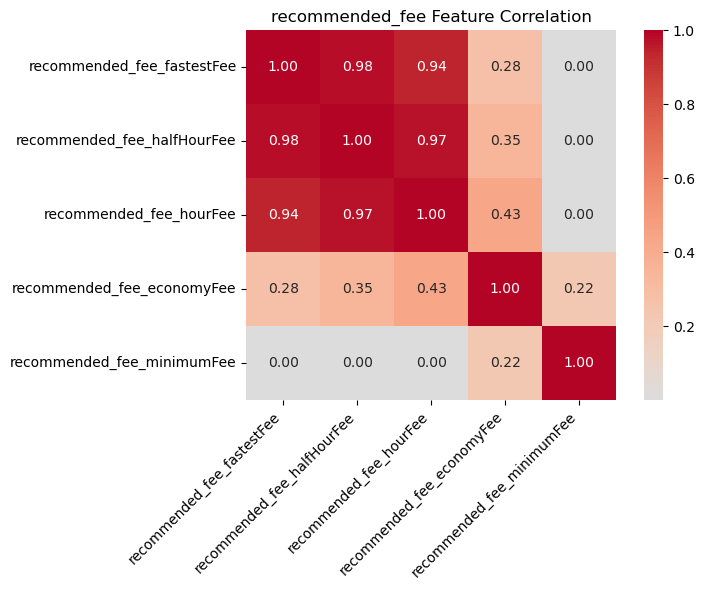

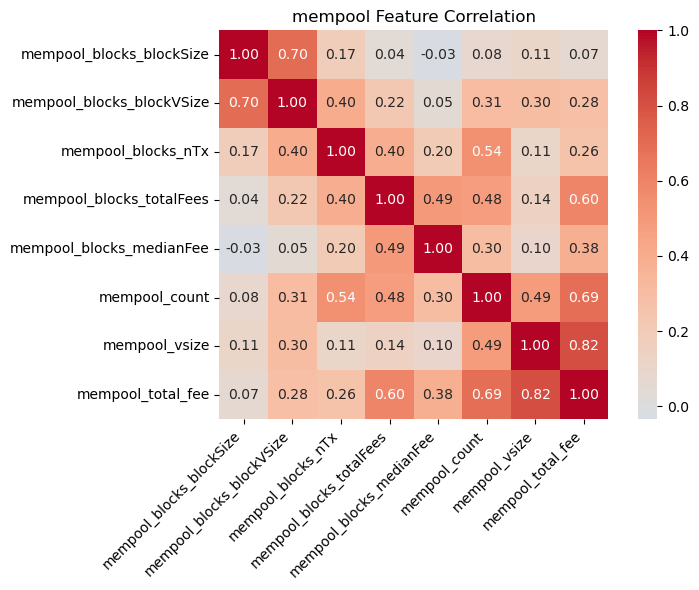

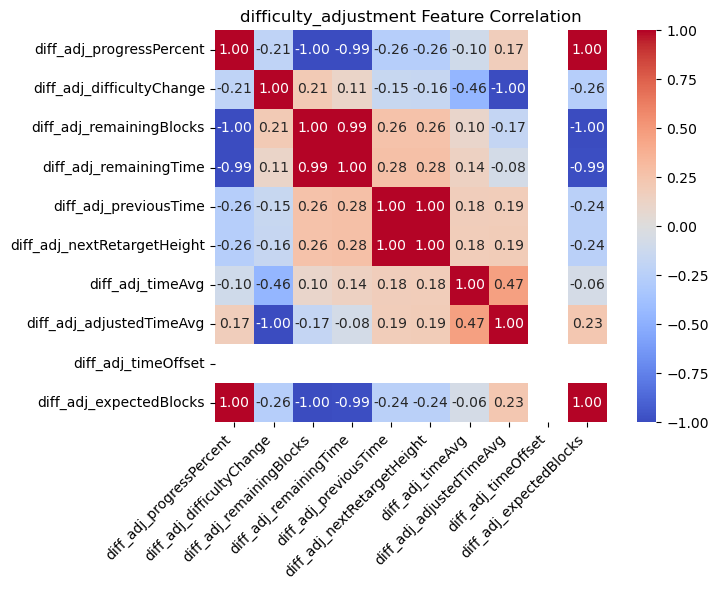

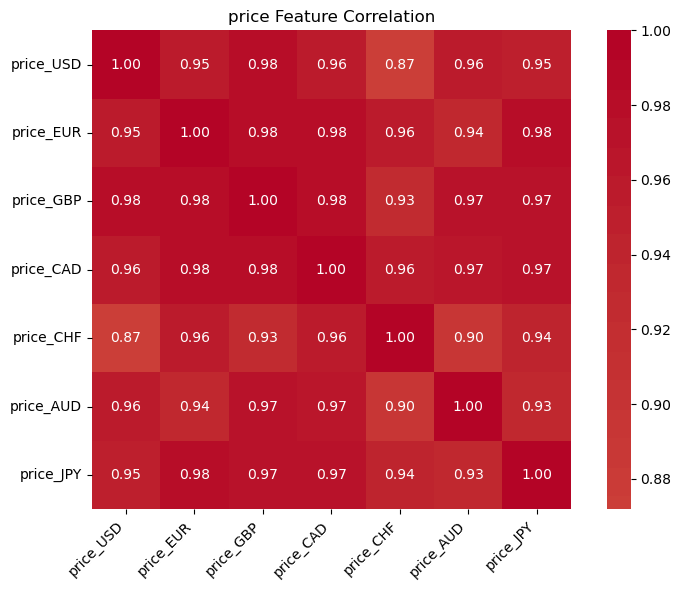

In [47]:
for group_name, prefix in group_prefixes.items():
    plot_group_correlation(df, group_name, prefix, exclude_prefixes = excluded_prefixes)


#### Key Insights:
The correlation heatmaps reveal several key relationships across feature groups:

- **Recommended Fee Group**  
  `fastestFee`, `halfHourFee`, and `hourFee` are highly correlated (p > 0.9), suggesting they capture similar network conditions.  
  In contrast, `economyFee` and `minimumFee` show weaker or no correlation, indicating they may reflect different user behavior (e.g., low-priority transactions).

- **Mempool Group**  
  Features like `mempool_vsize` and `mempool_total_fee` are strongly correlated (p > 0.8), likely due to shared dependence on transaction volume.  
  However, `mempool_blocks_medianFee` is weakly correlated with most others, potentially offering unique information about block-level fee trends.

- **Difficulty Adjustment Group**  
  Many features show perfect positive or negative correlations (e.g., `remainingBlocks` vs. `progressPercent`, r = -1.0), reflecting deterministic relationships from Bitcoin’s difficulty adjustment algorithm.  
  This suggests redundancy within the group and motivates dimensionality reduction (e.g., dropping derived variables).

- **Price Group**  
  All fiat-denominated Bitcoin prices (USD, EUR, GBP, etc.) are highly correlated (p > 0.9), as expected given stable exchange rates.  
  These features are interchangeable unless currency-specific effects are being studied.

---

These insights help:

- Identify **feature redundancy** (e.g., exact/inverse correlations in difficulty features)
- **Select representative variables** for modeling (e.g., keep one of the high-correlation fee types)
- **Avoid multicollinearity** when applying linear models or interpreting coefficients


### 10.2 Correlation Analysis with Significance Testing

We compute both **Pearson** and **Spearman** correlation matrices for selected congestion-related features to examine their relationships with the target variable `recommended_fee_fastestFee`.

To assess the reliability of these correlations, we also include **p-value checks** to confirm statistical significance.  
This helps ensure that observed correlations are not due to random variation.


In [53]:
corr_features = [
    "recommended_fee_fastestFee",
    "mempool_total_fee",
    "mempool_count",
    "mempool_blocks_nTx",
    "mempool_blocks_blockVSize",
    "difficulty_adjustment_difficultyChange",
    "mempool_blocks_totalFees"
]

label_map = {
    "recommended_fee_fastestFee": "Fastest Fee",
    "mempool_total_fee": "Mempool Total Fee",
    "mempool_count": "Mempool Count",
    "mempool_blocks_nTx": "Next Block # of Transaction",
    "mempool_blocks_blockVSize": "Block vSize",
    "difficulty_adjustment_difficultyChange": "Difficulty Change",
    "mempool_blocks_totalFees": "Next Block Total Fee"
}

# Prepare correlation and p-value matrices
pearson_corr = pd.DataFrame(index=corr_features, columns=corr_features)
pearson_pval = pd.DataFrame(index=corr_features, columns=corr_features)

spearman_corr = pd.DataFrame(index=corr_features, columns=corr_features)
spearman_pval = pd.DataFrame(index=corr_features, columns=corr_features)

for i in corr_features:
    for j in corr_features:
        x = df[i].dropna()
        y = df[j].dropna()
        common_idx = x.index.intersection(y.index)
        if len(common_idx) > 2:
            # Pearson
            r, p = pearsonr(x[common_idx], y[common_idx])
            pearson_corr.loc[i, j] = r
            pearson_pval.loc[i, j] = p
            # Spearman
            r_s, p_s = spearmanr(x[common_idx], y[common_idx])
            spearman_corr.loc[i, j] = r_s
            spearman_pval.loc[i, j] = p_s
            
# Convert to float and rename axes
pearson_corr = pearson_corr.astype(float).rename(index=label_map, columns=label_map)
spearman_corr = spearman_corr.astype(float).rename(index=label_map, columns=label_map)
pearson_pval = pearson_pval.astype(float).rename(index=label_map, columns=label_map)
spearman_pval = spearman_pval.astype(float).rename(index=label_map, columns=label_map)


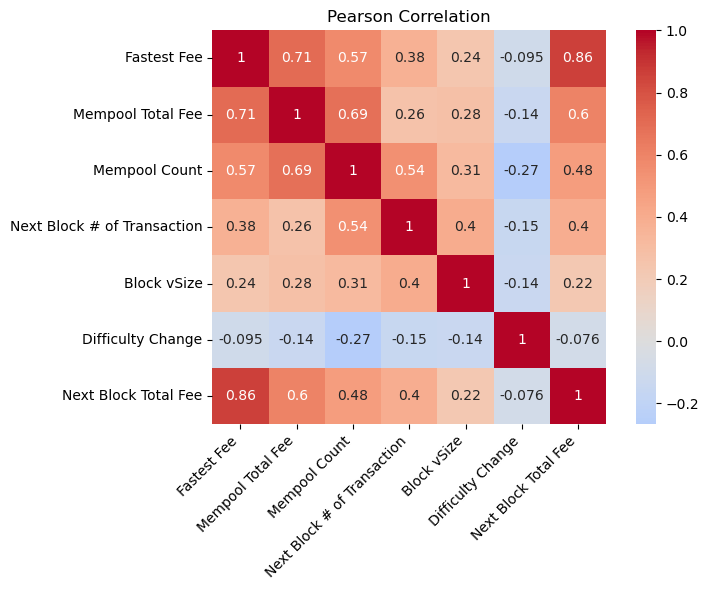

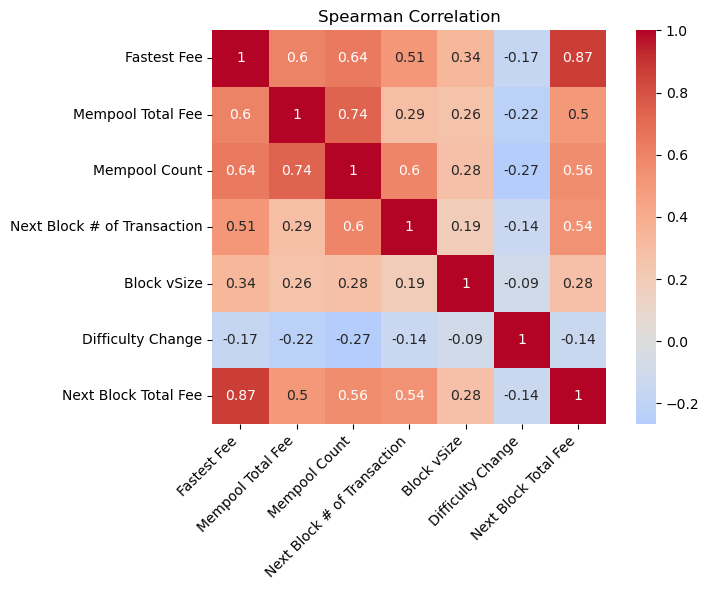

In [54]:
# Pearson correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr.astype(float), annot=True, cmap='coolwarm', center=0, square=True)
plt.xticks(rotation=45, ha='right')
plt.title("Pearson Correlation")
plt.tight_layout()
plt.savefig("../img/pearson_correlation.png", dpi=300)
plt.show()

# Spearman correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr.astype(float), annot=True, cmap='coolwarm', center=0, square=True)
plt.xticks(rotation=45, ha='right')
plt.title("Spearman Correlation")
plt.tight_layout()
plt.savefig("../img/spearman_correlation.png", dpi=300)
plt.show()

In [55]:
# Extract p-values and correlation against target
target = "Fastest Fee"
corr_summary = pd.DataFrame({
    'Pearson_corr': pearson_corr.loc[target],
    'Pearson_p': pearson_pval.loc[target],
    'Spearman_corr': spearman_corr.loc[target],
    'Spearman_p': spearman_pval.loc[target]
})

# Define formatter for p-values
def format_pval(p):
    """
    Formats a p-value for clean table display.

    Parameters:
        p (float or None): The p-value to format.

    Returns:
        str: A string representation of the p-value:
             - "<0.0001" if the value is very small,
             - "NA" if missing,
             - or rounded to 4 decimal places otherwise.
    """
    if pd.isnull(p):
        return "NA"
    elif p < 0.0001:
        return "<0.0001"
    else:
        return f"{p:.4f}"

# Apply formatting
corr_summary_formatted = corr_summary.copy()
corr_summary_formatted["Pearson_corr"] = corr_summary_formatted["Pearson_corr"].round(2)
corr_summary_formatted["Spearman_corr"] = corr_summary_formatted["Spearman_corr"].round(2)
corr_summary_formatted["Pearson_p"] = corr_summary_formatted["Pearson_p"].apply(format_pval)
corr_summary_formatted["Spearman_p"] = corr_summary_formatted["Spearman_p"].apply(format_pval)

# Display result
display(corr_summary_formatted)

,Pearson_corr,Pearson_p,Spearman_corr,Spearman_p
Fastest Fee,1.00,<0.0001,1.00,<0.0001
Mempool Total Fee,0.71,<0.0001,0.60,<0.0001
Mempool Count,0.57,<0.0001,0.64,<0.0001
Next Block # of Transaction,0.38,<0.0001,0.51,<0.0001
Block vSize,0.24,<0.0001,0.34,<0.0001
Difficulty Change,-0.09,<0.0001,-0.17,<0.0001
Next Block Total Fee,0.86,<0.0001,0.87,<0.0001


#### Key Insights:

Both Pearson and Spearman correlation analyses reveal statistically significant relationships between `recommended_fee_fastestFee` and several congestion-related features.

- **`mempool_blocks_totalFees`** shows the **strongest correlation** with the target, with r = 0.86 (Spearman) and r = 0.86 (Pearson), indicating it's a highly predictive variable.
- **`mempool_total_fee`**, **`mempool_count`**, and **`mempool_blocks_nTx`** also exhibit moderate-to-strong positive correlations (r = 0.5–0.7), reflecting their direct ties to network congestion.
- **`difficulty_adjustment_difficultyChange`** shows **low or negative correlation** and comparatively higher p-values (e.g., 0.024 in Pearson), suggesting its relationship with the target is weak or potentially non-causal.

All other features show **p-values < 0.0001**, confirming that observed correlations are statistically significant and unlikely to result from chance.

This dual-method approach (Pearson for linear, Spearman for monotonic trends) confirms both the **magnitude** and **directional consistency** of relationships, strengthening confidence in using these variables for downstream modeling and feature selection.


## 11. Modeling Strategy Informed by EDA

We summarize EDA insights to justify modeling choices and guide the overall forecasting strategy.

---

### Key Observations from EDA

- **Stationarity:**  
  ADF tests confirm that the target variable `fastestFee` is stationary. Differencing is not needed for ARIMA-family models.

- **Seasonality:**  
  Strong daily seasonality is evident after 15-minute resampling (96 intervals per day).  
  Weekly seasonality was tested but found to be weak and inconsistent.

- **Volatility:**  
  The target exhibits congestion-driven spikes and sharp variability, making it challenging for linear models to fully capture.

- **Correlations:**  
  Features like `mempool_total_fee`, `mempool_blocks_totalFees`, and `mempool_count` are highly correlated with the target, offering strong predictive signals.

- **Multivariate Signals:**  
  The dataset includes a diverse set of features across mempool state, block metrics, difficulty adjustment, and market price—supporting multivariate time series modeling.

---

### Model Strategy

Based on these findings, we adopt a two-stage modeling strategy to balance interpretability, robustness, and forecasting performance.

#### 1. Baseline Models
- **SARIMA (Seasonal ARIMA):**  
  Leverages autocorrelation and seasonality in a univariate setting (with `seasonal_period = 96`).
- **HWES (Holt-Winters Exponential Smoothing):**  
  Captures level and seasonal patterns with minimal tuning; suitable for short-term seasonal forecasting.
- **XGBoost:**  
  A tree-based model capable of handling nonlinearity, lagged inputs, and multivariate dependencies.

#### 2. Advanced Models
- **Prophet:**  
  Decompositional model that handles missing data and strong seasonality well; interpretable and scalable.
- **DeepAR:**  
  Recurrent neural network designed for sequential probabilistic forecasting on time series data.
- **Temporal Fusion Transformer (TFT):**  
  A state-of-the-art attention-based model that captures temporal dependencies and interactions across multiple features with built-in interpretability.

---

This strategy allows us to:
- Benchmark traditional univariate time series models (e.g., SARIMA, HWES) against machine learning and deep learning alternatives;
- Assess the added value of incorporating exogenous variables and seasonal terms in multivariate models (e.g., XGBoost, DeepAR, TFT);
- Progressively move toward a performant and interpretable forecasting pipeline.

---

## EDA Summary

### 1. Distributional Analysis
- `fastestFee` is highly skewed and volatile, with spikes during congestion periods.
- Fee bin counts were log-transformed to reduce skewness and stabilize variance.
- Several features (e.g., `mempool_count`, `price_USD`, `block_interval`) exhibit long-tailed distributions, suggesting potential benefit from normalization.

### 2. Seasonality and Trend
- Seasonal decomposition reveals strong and consistent daily cycles.
- Weekly patterns (672 intervals) were tested but showed no stable or repeating structure.
- Both additive and multiplicative decompositions support inclusion of seasonal components in modeling.

### 3. Stationarity Checks
- ADF test confirms stationarity of the target (p < 0.01); no differencing is required.
- Rolling mean and standard deviation are relatively stable.
- ACF and PACF plots suggest AR(2)-like structure.

### 4. Modeling Preparation
- Key features selected across four domains: fee estimates, mempool metrics, block-level stats, and market prices.
- Lag features are motivated by autocorrelation patterns.
- The dataset supports both univariate models (SARIMA, HWES) and multivariate models (XGBoost, DeepAR, TFT).
